# 3D image classification from CT scans

**Author:** [exonys](https://github.com/ezsx)<br>
**Date created:** 2023/12/19<br>
**Last modified:** 2020/12/19<br>
**Description:** Train a 3D convolutional neural network to predict presence of pneumonia.

## Introduction

This example will show the steps needed to build a 3D convolutional neural network (CNN)
to predict the presence of viral pneumonia in computer tomography (CT) scans. 2D CNNs are
commonly used to process RGB images (3 channels). A 3D CNN is simply the 3D
equivalent: it takes as input a 3D volume or a sequence of 2D frames (e.g. slices in a CT scan),
3D CNNs are a powerful model for learning representations for volumetric data.

## References

- [A survey on Deep Learning Advances on Different 3D DataRepresentations](https://arxiv.org/pdf/1808.01462.pdf)
- [VoxNet: A 3D Convolutional Neural Network for Real-Time Object Recognition](https://www.ri.cmu.edu/pub_files/2015/9/voxnet_maturana_scherer_iros15.pdf)
- [FusionNet: 3D Object Classification Using MultipleData Representations](http://3ddl.cs.princeton.edu/2016/papers/Hegde_Zadeh.pdf)
- [Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction](https://arxiv.org/abs/2007.13224)

## Setup

In [2]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from skimage import exposure
from skimage.morphology import ball
# from skimage.segmentation._felzenszwalb_cy import gaussian
from skimage.filters import gaussian
from keras.models import Model  # Add this import statement



2023-12-21 08:06:01.195956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 08:06:01.196047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 08:06:01.197413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 08:06:01.206079: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 08:06:02.208265: W tensorflow/compiler/tf2

In [4]:
# Тестим наличие видиокарты
from tensorflow.python.client import device_lib
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(tf.config.experimental.get_memory_info("GPU:0")["current"])
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('False')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


0
1 Physical GPUs, 1 Logical GPUs


## Loading data and preprocessing

In [ ]:
import os
from tqdm import tqdm
import zipfile


def extract_zip_file(zip_path, extract_to_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get a list of file names in the zip file
        file_names = zip_ref.namelist()
        # Set up your progress bar with the total number of files
        with tqdm(total=len(file_names), desc=f"Extracting {os.path.basename(zip_path)}", unit='file') as pbar:
            for file in file_names:
                # Extract each file to the directory
                zip_ref.extract(member=file, path=extract_to_dir)
                # Update the progress bar by one step
                pbar.update(1)
        print(f"Extracted: {zip_path}")

def extract_zip_files(zip_dir, extract_to_dir):
    """
    Extracts all zip files found in the specified directory.
    """
    zip_files = [zip_file for zip_file in os.listdir(zip_dir) if zip_file.endswith('.zip')]
    for zip_file in zip_files:
        zip_path = os.path.join(zip_dir, zip_file)
        extract_zip_file(zip_path, extract_to_dir)




# Example usage:
zip_dir = "/mnt/c/3D_class/MosMedData-CT-HEMORRHAGE-type VIII"  # Replace with your directory containing the zip files
extract_to_dir = "/mnt/c/3D_class/MosMedData-CT-unzip"  # Replace with where you want to extract the studies

# Step 1: Extract the zip files
extract_zip_files(zip_dir, extract_to_dir)
# source_dir/
#   patient001/
#     series001/
#       .dcm files



Extracting 0_100_studies.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46109/46109 [17:09<00:00, 44.80file/s]


Extracted: /mnt/c/3D_class/MosMedData-CT-HEMORRHAGE-type VIII/0_100_studies.zip


Extracting 100_200_studies.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40492/40492 [15:04<00:00, 44.76file/s]


Extracted: /mnt/c/3D_class/MosMedData-CT-HEMORRHAGE-type VIII/100_200_studies.zip


Extracting 200_300_studies.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41947/41947 [15:46<00:00, 44.34file/s]


Extracted: /mnt/c/3D_class/MosMedData-CT-HEMORRHAGE-type VIII/200_300_studies.zip


Extracting 300_400_studies.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37733/37733 [13:52<00:00, 45.31file/s]


Extracted: /mnt/c/3D_class/MosMedData-CT-HEMORRHAGE-type VIII/300_400_studies.zip


Extracting 400_500_studies.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47353/47353 [17:20<00:00, 45.50file/s]


Extracted: /mnt/c/3D_class/MosMedData-CT-HEMORRHAGE-type VIII/400_500_studies.zip


Extracting 500_600_studies.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50039/50039 [19:03<00:00, 43.78file/s]


Extracted: /mnt/c/3D_class/MosMedData-CT-HEMORRHAGE-type VIII/500_600_studies.zip


Extracting 600_700_studies.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50698/50698 [20:14<00:00, 41.75file/s]


Extracted: /mnt/c/3D_class/MosMedData-CT-HEMORRHAGE-type VIII/600_700_studies.zip


Extracting 700_800_studies.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50992/50992 [19:23<00:00, 43.84file/s]


Extracted: /mnt/c/3D_class/MosMedData-CT-HEMORRHAGE-type VIII/700_800_studies.zip


Converting DICOM to NIfTI:   0%|                                                                                                                                                                                                                                                             | 0/8 [00:00<?, ?dir/s]/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06000710020011090113150209031410'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07130603120704081407040607081408'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg

In [1]:
import os
import dicom2nifti
from tqdm import tqdm


def convert_dicom_to_nifti(dicom_directory, output_directory):
    import warnings
    with warnings.catch_warnings():
        subdirs = [d for d in os.listdir(dicom_directory) if os.path.isdir(os.path.join(dicom_directory, d))]
        for subdir in tqdm(subdirs, desc="Converting DICOM to NIfTI"):
            dicom_path = os.path.join(dicom_directory, subdir)
            nifti_path = os.path.join(output_directory, subdir)
            if not os.path.exists(nifti_path):
                os.makedirs(nifti_path, exist_ok=True)
                try:
                    dicom2nifti.convert_directory(dicom_path, nifti_path, compression=False)
                    print(f"Converted {dicom_path} to NIfTI format in {nifti_path}")
                    # unpack_single_gzip_in_folder(nifti_path, subdir)
                except Exception as e:
                    print(f"Failed to convert {dicom_path}: {e}")

def parse_packs(packs_directory, output_directory):
    packs = [d for d in os.listdir(packs_directory) if os.path.isdir(os.path.join(packs_directory, d))]
    for pack in tqdm(packs, desc="Processing packs"):
        pack_path = os.path.join(packs_directory, pack)
        output_directory = os.path.join(output_directory, pack + '_nifti')
        convert_dicom_to_nifti(pack_path, output_directory)

# Define your directory paths here

dicom_dir = "/mnt/c/3D_class/MosMedData-CT-unzip"
nifti_output_dir = "/mnt/c/3D_class/MosMedData-CT-nifti"

# Process each pack
parse_packs(dicom_dir,nifti_output_dir)

Converting DICOM to NIfTI:   0%|                                                                                                                                                                                                                                                            | 0/100 [00:00<?, ?it/s]/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06000710020011090113150209031410'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07130603120704081407040607081408'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.00000312101100040009080805131200 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00000312101100040009080805131200



Converting DICOM to NIfTI:   2%|████▉                                                                                                                                                                                                                                               | 2/100 [00:28<23:05, 14.13s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.00020803141509060306140908060606 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00020803141509060306140908060606



Converting DICOM to NIfTI:   3%|███████▎                                                                                                                                                                                                                                            | 3/100 [00:44<24:24, 15.10s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.00040514141511080005000509050010 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00040514141511080005000509050010



Converting DICOM to NIfTI:   4%|█████████▊                                                                                                                                                                                                                                          | 4/100 [00:55<21:35, 13.49s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.00060407110511120709131406060707 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00060407110511120709131406060707



Converting DICOM to NIfTI:   5%|████████████▏                                                                                                                                                                                                                                       | 5/100 [00:58<15:34,  9.84s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.00101410131506010412010300111515 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00101410131506010412010300111515



Converting DICOM to NIfTI:   6%|██████████████▋                                                                                                                                                                                                                                     | 6/100 [01:08<15:04,  9.62s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.00120312001308111003080406111314 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00120312001308111003080406111314


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00130510090701041405100011051204'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   7%|█████████████████                                                                                                                                                                                                                                   | 7/100 [01:20<16:07, 10.40s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.00130702150802080115010312040812 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00130702150802080115010312040812


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00141208070314071005080302110407'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05140706001012141108100803091213'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   8%|███████████████████▌                                                                                                                                                                                                                                | 8/100 [01:37<19:27, 12.69s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.00150413091311101303090802090701 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00150413091311101303090802090701


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03060304111300110408080215150006'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   9%|█████████████████████▉                                                                                                                                                                                                                              | 9/100 [01:49<19:01, 12.54s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.00151501040710070705060806071504 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00151501040710070705060806071504


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07040401131514141102101513030103'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  10%|████████████████████████▎                                                                                                                                                                                                                          | 10/100 [02:00<17:43, 11.82s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.01020703100303120813121001091004 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01020703100303120813121001091004



Converting DICOM to NIfTI:  11%|██████████████████████████▋                                                                                                                                                                                                                        | 11/100 [02:09<16:11, 10.91s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.01050212090213050813060204050805 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01050212090213050813060204050805



Converting DICOM to NIfTI:  12%|█████████████████████████████▏                                                                                                                                                                                                                     | 12/100 [02:25<18:18, 12.49s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.01060802030706091402150511040210 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01060802030706091402150511040210



Converting DICOM to NIfTI:  13%|███████████████████████████████▌                                                                                                                                                                                                                   | 13/100 [02:52<24:46, 17.09s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.01070007070308031013141103140614 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01070007070308031013141103140614


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00010013000707030009111114060011'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  14%|██████████████████████████████████                                                                                                                                                                                                                 | 14/100 [03:02<21:24, 14.94s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.01081415010400000307121410061104 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01081415010400000307121410061104


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05040204140803001105101110051504'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  15%|████████████████████████████████████▍                                                                                                                                                                                                              | 15/100 [03:32<27:40, 19.53s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.01090304051508030010031005120702 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01090304051508030010031005120702


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00010010030802121214040106021210'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04060104020006040614070911040608'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  16%|██████████████████████████████████████▉                                                                                                                                                                                                            | 16/100 [03:49<26:03, 18.62s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.01141111071406061111111510130400 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01141111071406061111111510130400



Converting DICOM to NIfTI:  17%|█████████████████████████████████████████▎                                                                                                                                                                                                         | 17/100 [04:26<33:13, 24.02s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.02031104070814111001150402130115 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02031104070814111001150402130115


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06081207040111141409061414090212'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  18%|███████████████████████████████████████████▋                                                                                                                                                                                                       | 18/100 [04:35<26:52, 19.67s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.02040003120406051107020908120507 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02040003120406051107020908120507


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06051500130805061011000114100514'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  19%|██████████████████████████████████████████████▏                                                                                                                                                                                                    | 19/100 [05:05<30:42, 22.74s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.02041505101112010004080111111204 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02041505101112010004080111111204


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01110512010010070605121409130102'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  20%|████████████████████████████████████████████████▌                                                                                                                                                                                                  | 20/100 [05:30<31:08, 23.36s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.02070704150410020214060302121408 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02070704150410020214060302121408


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02001304061000000911051504111310'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  21%|███████████████████████████████████████████████████                                                                                                                                                                                                | 21/100 [06:02<34:20, 26.09s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.02110701081514000302140504081403 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02110701081514000302140504081403


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00080702000801001408100606121508'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  22%|█████████████████████████████████████████████████████▍                                                                                                                                                                                             | 22/100 [06:30<34:34, 26.59s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.02130813070705061113120001080315 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02130813070705061113120001080315


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06050715061213050514120401071004'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  23%|███████████████████████████████████████████████████████▉                                                                                                                                                                                           | 23/100 [07:04<37:10, 28.97s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.03020608150215050209100908011005 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03020608150215050209100908011005


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05070408121203020403060311000614'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  24%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 24/100 [07:36<37:33, 29.65s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.03031109120904100209121013031315 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03031109120904100209121013031315


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00120100060911100514071007031310'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  25%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 25/100 [08:07<37:38, 30.11s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.03060602071001090400101312060104 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03060602071001090400101312060104



Converting DICOM to NIfTI:  26%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 26/100 [08:33<35:46, 29.01s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.03141302130609081315020913121010 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03141302130609081315020913121010


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07061214131507070909120504021305'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  27%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 27/100 [08:51<31:08, 25.59s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.03141508091404000801081506051310 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03141508091404000801081506051310


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01020911000307121413030613001510'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  28%|████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 28/100 [09:00<24:50, 20.70s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.03141510151005110712051409040007 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03141510151005110712051409040007


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05060506130400130510150209011513'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  29%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 29/100 [09:31<28:09, 23.80s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.04030409050605001409120711000506 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04030409050605001409120711000506



Converting DICOM to NIfTI:  30%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                          | 30/100 [09:42<23:08, 19.83s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.04040004031301030606071505020602 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04040004031301030606071505020602


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09141002101510150004140202010110'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  31%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 31/100 [09:53<19:52, 17.28s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.04050306001014050413141007061501 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04050306001014050413141007061501



Converting DICOM to NIfTI:  32%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 32/100 [10:03<16:55, 14.93s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.04080200141111031415150414061012 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04080200141111031415150414061012



Converting DICOM to NIfTI:  33%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 33/100 [10:05<12:36, 11.30s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.04101409031308070600050609030909 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04101409031308070600050609030909


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07130108070601000614070806000314'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  34%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                | 34/100 [10:22<14:04, 12.79s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.04121503101203140708090213050007 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04121503101203140708090213050007


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09140003050813041509020206110000'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  35%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 35/100 [10:57<21:05, 19.47s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.04150405080014101309101200080803 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04150405080014101309101200080803


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08111104011208001215100909131107'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  36%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 36/100 [11:07<17:55, 16.81s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.05000505110604101210121404010100 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05000505110604101210121404010100


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05030402080300051215090209000205'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  37%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 37/100 [11:49<25:21, 24.16s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.05010402050901000203040514091400 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05010402050901000203040514091400


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03030405080507070902021304040002'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09100111080707010908130913140002'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  38%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 38/100 [12:11<24:22, 23.58s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.05021404011505050605120209110908 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05021404011505050605120209110908


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04150808010710060113140506071407'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  39%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 39/100 [12:40<25:30, 25.09s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.05030209111304090812091101080110 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05030209111304090812091101080110


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08050700130502080901140206001012'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 40/100 [13:10<26:44, 26.74s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.05050612121402051406080302050311 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05050612121402051406080302050311



Converting DICOM to NIfTI:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 41/100 [13:20<21:16, 21.63s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.05090012070004141212090806010310 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05090012070004141212090806010310



Converting DICOM to NIfTI:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 42/100 [13:47<22:32, 23.33s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.05091210131205060013100607001400 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05091210131205060013100607001400


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00080003110000010214131013071206'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 43/100 [13:56<17:59, 18.93s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.05111004101103140401061411140915 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05111004101103140401061411140915



Converting DICOM to NIfTI:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 44/100 [14:09<16:01, 17.16s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.05131006130910150002061109130002 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05131006130910150002061109130002


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03120708020711111213131311070802'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 45/100 [14:33<17:42, 19.33s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.05140902080413071203080202041405 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05140902080413071203080202041405


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01040713020511150612130909051100'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 46/100 [14:42<14:35, 16.22s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.06000111071507040610090702150509 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06000111071507040610090702150509



Converting DICOM to NIfTI:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 47/100 [14:46<11:03, 12.51s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.06000304080803110112010502141412 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06000304080803110112010502141412


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05010009081314011201101002150907'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 48/100 [14:54<09:34, 11.04s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.06021003150910101012141213150207 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06021003150910101012141213150207


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04021000030402141405141214100707'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 49/100 [15:02<08:40, 10.21s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.06031507030612120510011302110111 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06031507030612120510011302110111



Converting DICOM to NIfTI:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 50/100 [15:12<08:24, 10.10s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.06040515040312121212030606120515 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06040515040312121212030606120515


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06151406010013010211001509130202'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 51/100 [15:51<15:23, 18.84s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.06041209100411100402011115120002 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06041209100411100402011115120002



Converting DICOM to NIfTI:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 52/100 [16:18<17:06, 21.39s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.06120500141501150114131414081115 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06120500141501150114131414081115



Converting DICOM to NIfTI:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 53/100 [16:51<19:25, 24.80s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.06150002111514020902140803100608 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06150002111514020902140803100608


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08091305120905021410140815141313'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 54/100 [17:23<20:37, 26.89s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.07041307151215090202050311061409 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07041307151215090202050311061409


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03130907110902151500061202020114'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 55/100 [17:35<16:47, 22.40s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.07081315001107050500091502060303 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07081315001107050500091502060303


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02011311070403100306080909031513'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 56/100 [17:54<15:46, 21.50s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.07140909141306061414051310140500 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07140909141306061414051310140500



Converting DICOM to NIfTI:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 57/100 [18:11<14:23, 20.08s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.07150113081410041403110314130211 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07150113081410041403110314130211


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04101304040003140507001015091214'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 58/100 [18:45<16:56, 24.21s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.08080403121313070010121214130114 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08080403121313070010121214130114


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09030109141505060802121312071112'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 59/100 [18:57<14:07, 20.68s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.08100114131010011411131109130614 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08100114131010011411131109130614


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06040712021400030514080306151202'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 60/100 [19:31<16:22, 24.56s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.08130209100515150114111507040008 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08130209100515150114111507040008


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05050000130015100801110409141306'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 61/100 [19:55<15:51, 24.40s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.09000706120101040302061306000911 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09000706120101040302061306000911



Converting DICOM to NIfTI:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 62/100 [20:05<12:50, 20.27s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.09031501131409120411100814151404 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09031501131409120411100814151404



Converting DICOM to NIfTI:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 63/100 [20:19<11:12, 18.17s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.09041103020213061505131000021000 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09041103020213061505131000021000


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03010104050312021504080904051110'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04090700110301081315130004121111'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 64/100 [20:37<10:56, 18.22s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.09071314130704040804120814121001 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09071314130704040804120814121001



Converting DICOM to NIfTI:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 65/100 [21:16<14:17, 24.50s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.09080202110307041402151314030215 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09080202110307041402151314030215



Converting DICOM to NIfTI:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 66/100 [21:28<11:44, 20.72s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.09090907141414120304020400050108 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09090907141414120304020400050108


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00081209141501070806011414010008'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 67/100 [21:38<09:36, 17.48s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.09100805030412080214021305000407 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09100805030412080214021305000407


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00050014150014101009080005091105'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 68/100 [21:50<08:22, 15.70s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.10010712060613130015140600090904 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10010712060613130015140600090904


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08000107040901070510121301050211'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 69/100 [22:04<07:55, 15.33s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.10061111090402060902061306041201 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10061111090402060902061306041201


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01060707151103050110030607110603'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 70/100 [22:22<07:59, 15.99s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.10080707110009100101000908090802 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10080707110009100101000908090802


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07091206011215150910111515050907'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 71/100 [22:33<07:03, 14.60s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.10090711140612140505150208141203 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10090711140612140505150208141203


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01000610041107061414081214021115'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 72/100 [22:58<08:12, 17.59s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.10120602000601100709031114000102 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10120602000601100709031114000102



Converting DICOM to NIfTI:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 73/100 [23:09<07:02, 15.64s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.10130802141211010705111512130804 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10130802141211010705111512130804


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06000511100703070410001513010313'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 74/100 [23:20<06:15, 14.45s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.10131009030102121104101305040405 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10131009030102121104101305040405


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06031402050009050900000302030003'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 75/100 [23:29<05:19, 12.79s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.11021205000405011103130207151200 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11021205000405011103130207151200



Converting DICOM to NIfTI:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 76/100 [23:42<05:07, 12.82s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.11060103091005010608070601010913 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11060103091005010608070601010913


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07000410031008101112130809001214'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Slice increment not consistent through all slices
---------------------------------------------------------
[-104.801    -92.30103 -458.7    ] [ 0.   0.  -0.3]
[-104.801    -92.30103 -458.1    ] [ 0.   0.  -0.6]
Instance Number: 374
---------------------------------------------------------
Traceback (most recent call last):
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dir.py", line 85, in convert_directory
    convert_dicom.dicom_array_to_nifti(dicom_input, nifti_file, reorient)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dicom.py", line 11

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.11071505060110041109011212121003 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11071505060110041109011212121003



Converting DICOM to NIfTI:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 78/100 [24:01<04:12, 11.48s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.11131011120300020604060008141115 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11131011120300020604060008141115


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01081106011305121311141510011401'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 79/100 [24:10<03:43, 10.62s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.12050009080801141000091107100312 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12050009080801141000091107100312


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05120706080014020814010315000007'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 80/100 [24:45<06:01, 18.10s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.12080400041105050206041013020301 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12080400041105050206041013020301



Converting DICOM to NIfTI:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 81/100 [25:11<06:24, 20.25s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.12090413150513130306050403080911 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12090413150513130306050403080911


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05060713020912040111131210000303'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 82/100 [25:36<06:29, 21.63s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.12100603091102140112150804140706 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12100603091102140112150804140706



Converting DICOM to NIfTI:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 83/100 [26:02<06:32, 23.11s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.12111101051200140000131200051509 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12111101051200140000131200051509



Converting DICOM to NIfTI:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 84/100 [26:32<06:42, 25.14s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.12130713100607060005081306080611 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12130713100607060005081306080611



Converting DICOM to NIfTI:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 85/100 [26:53<05:56, 23.78s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.13040703130112040105120306141109 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13040703130112040105120306141109


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03011003110511110507001400040812'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 86/100 [27:04<04:41, 20.08s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.13071106071307021104080610050408 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13071106071307021104080610050408



Converting DICOM to NIfTI:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 87/100 [27:36<05:07, 23.62s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.13110311140307000715090310000515 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13110311140307000715090310000515


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02121310020906100504130611011312'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 88/100 [27:48<04:02, 20.23s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.13121212020413080615061112000904 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13121212020413080615061112000904


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09080813010606150008061200091012'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 89/100 [28:20<04:19, 23.56s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.13140305060812041409080300091409 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13140305060812041409080300091409


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00110701141401140814120108110706'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 90/100 [28:31<03:19, 19.99s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.14001507020807131402151406001108 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14001507020807131402151406001108


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02131500021210020308090204131409'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 91/100 [28:46<02:46, 18.55s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.14100506000708040109150104000414 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14100506000708040109150104000414


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07120709060310060815130914111504'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 92/100 [29:25<03:15, 24.46s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.14140300010212040714021213150413 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14140300010212040714021213150413


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02021514141010000309010210040113'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03110612000310140714031214151500'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 93/100 [29:40<02:32, 21.74s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.14141010011304121310091209120311 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14141010011304121310091209120311



Converting DICOM to NIfTI:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 94/100 [29:51<01:51, 18.63s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.15020800061404150210140309111506 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15020800061404150210140309111506


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02151314130704020512021300140413'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 95/100 [30:10<01:33, 18.69s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.15040103050314030307100901090600 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15040103050314030307100901090600



Converting DICOM to NIfTI:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 96/100 [30:19<01:02, 15.60s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.15040604070208011301131511011409 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15040604070208011301131511011409


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00091412120011100814020108090603'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 97/100 [31:04<01:13, 24.42s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.15060306040501040613061206071100 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15060306040501040613061206071100


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02090100091206130012100305070612'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03090608031104040010031110030802'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 98/100 [31:18<00:42, 21.37s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.15060710140911090715101005141204 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15060710140911090715101005141204



Converting DICOM to NIfTI:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 99/100 [31:30<00:18, 18.68s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.15080000061512071310100608020408 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15080000061512071310100608020408


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02120604051410051000031300081009'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Processing packs:  12%|███████████████████████████████▍                                                                                                                                                                                                                           | 1/8 [31:57<3:43:40, 1917.22s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/0_100_studies/1.2.643.5.1.13.13.12.2.77.8252.15080902150406111503090500110708 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15080902150406111503090500110708



Converting DICOM to NIfTI:   0%|                                                                                                                                                                                                                                                            | 0/100 [00:00<?, ?it/s]/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04131000131305000908050901021113'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   1%|██▍                                                                                                                                                                                                                                                 | 1/100 [00:10<17:16, 10.47s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.00000000061409051407060207140912 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00000000061409051407060207140912



Converting DICOM to NIfTI:   2%|████▉                                                                                                                                                                                                                                               | 2/100 [00:17<14:11,  8.69s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.00000209100310101115081103041409 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00000209100310101115081103041409



Converting DICOM to NIfTI:   3%|███████▎                                                                                                                                                                                                                                            | 3/100 [00:26<14:08,  8.74s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.00010501060400041004130500151206 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00010501060400041004130500151206


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04111007130912010208050300110102'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   4%|█████████▊                                                                                                                                                                                                                                          | 4/100 [00:43<18:51, 11.79s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.00021203131405131312091303151015 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00021203131405131312091303151015


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01040007061510041104050003090309'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   5%|████████████▏                                                                                                                                                                                                                                       | 5/100 [00:54<18:07, 11.45s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.00050503130310120200020914090410 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00050503130310120200020914090410


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08150413120815040409111211011512'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   6%|██████████████▋                                                                                                                                                                                                                                     | 6/100 [00:55<12:42,  8.11s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.00051202101011101103020103071015 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00051202101011101103020103071015


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03031506021400000113060403041408'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   7%|█████████████████                                                                                                                                                                                                                                   | 7/100 [01:13<17:29, 11.29s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.00080708050203131114061211071210 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00080708050203131114061211071210


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05060007050511060215051015080313'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   8%|███████████████████▌                                                                                                                                                                                                                                | 8/100 [01:36<23:02, 15.03s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.00091104050707010606040703141115 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00091104050707010606040703141115


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09070800130208111413141506110512'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   9%|█████████████████████▉                                                                                                                                                                                                                              | 9/100 [01:50<22:04, 14.55s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.01111414140405030506030301040505 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01111414140405030506030301040505



Converting DICOM to NIfTI:  10%|████████████████████████▎                                                                                                                                                                                                                          | 10/100 [02:21<29:38, 19.76s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.01140811061408110212120714101103 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01140811061408110212120714101103


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01090206070612090211100102060213'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  11%|██████████████████████████▋                                                                                                                                                                                                                        | 11/100 [02:47<32:08, 21.67s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.02051011031008091210070605060112 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02051011031008091210070605060112


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00140801040402030302080613001407'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  12%|█████████████████████████████▏                                                                                                                                                                                                                     | 12/100 [02:58<26:55, 18.36s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.03000100070105140208040213000403 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03000100070105140208040213000403


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04011104121404131512060401141410'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  13%|███████████████████████████████▌                                                                                                                                                                                                                   | 13/100 [03:06<22:00, 15.18s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.03000314001215070901011101021408 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03000314001215070901011101021408


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00071401110312130404040414141211'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  14%|██████████████████████████████████                                                                                                                                                                                                                 | 14/100 [03:34<27:21, 19.09s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.03010712001406021001110705060214 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03010712001406021001110705060214


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05030501101502140602021102060206'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  15%|████████████████████████████████████▍                                                                                                                                                                                                              | 15/100 [04:07<32:58, 23.28s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.03090608110208060507150403070702 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03090608110208060507150403070702


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04081014151004020907140502130006'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  16%|██████████████████████████████████████▉                                                                                                                                                                                                            | 16/100 [04:20<28:14, 20.18s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.03091111041309110501030813060006 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03091111041309110501030813060006


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09151510010408080512130109030502'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  17%|█████████████████████████████████████████▎                                                                                                                                                                                                         | 17/100 [04:40<27:52, 20.15s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.03110501130706071309141415071214 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03110501130706071309141415071214


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06000711130110021504080911151000'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  18%|███████████████████████████████████████████▋                                                                                                                                                                                                       | 18/100 [05:11<32:00, 23.42s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.03140201150507140609091512131513 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03140201150507140609091512131513


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02000500091201001015050600020008'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  19%|██████████████████████████████████████████████▏                                                                                                                                                                                                    | 19/100 [05:30<29:52, 22.13s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.04001402010114100008070001090103 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04001402010114100008070001090103


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02050703101112030714150015080715'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  20%|████████████████████████████████████████████████▌                                                                                                                                                                                                  | 20/100 [05:59<32:24, 24.30s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.04031403060100071113131403041102 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04031403060100071113131403041102


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04030204090005060406010809061312'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  21%|███████████████████████████████████████████████████                                                                                                                                                                                                | 21/100 [06:49<41:59, 31.89s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.04070615020510070701101112091510 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04070615020510070701101112091510


Orthogonality check failed: non cubical image
---------------------------------------------------------
[-0.          0.25037943  0.96814779]
[0. 0. 1.]
---------------------------------------------------------
Traceback (most recent call last):
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dir.py", line 85, in convert_directory
    convert_dicom.dicom_array_to_nifti(dicom_input, nifti_file, reorient)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dicom.py", line 117, in dicom_array_to_nifti
    results = convert_generic.dicom_to_nifti(dicom_list, output_file)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_generic.py", line 241, in dicom_to_nifti
    common.validate_orthogonal(dicom_input)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.04101411130314140906100714130506 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04101411130314140906100714130506



Converting DICOM to NIfTI:  23%|███████████████████████████████████████████████████████▉                                                                                                                                                                                           | 23/100 [07:25<33:05, 25.79s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.04120615150315080502060505000707 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04120615150315080502060505000707


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05140209120003061107100802040105'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  24%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 24/100 [07:37<27:13, 21.49s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.04130506101507111406051505050803 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04130506101507111406051505050803



Converting DICOM to NIfTI:  25%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 25/100 [07:48<23:00, 18.41s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.04150200000913150311001501041401 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04150200000913150311001501041401


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03041110030710051512011401000410'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  26%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 26/100 [08:06<22:35, 18.31s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.05000514040703121101051111121400 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05000514040703121101051111121400


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08011200020603050401041003071414'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  27%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 27/100 [08:14<18:26, 15.16s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.05010106000007060806000502030907 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05010106000007060806000502030907


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01001004071403041410011515120404'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  28%|████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 28/100 [08:26<17:19, 14.43s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.05040806001208091115110314050604 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05040806001208091115110314050604


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08130406021200141009101305150215'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  29%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 29/100 [08:37<15:35, 13.18s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.05041000011408090011051406010305 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05041000011408090011051406010305



Converting DICOM to NIfTI:  30%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                          | 30/100 [08:49<15:00, 12.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.05111209040007051301040808110204 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05111209040007051301040808110204



Converting DICOM to NIfTI:  31%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 31/100 [08:59<13:46, 11.98s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.05120712051102060408041112081109 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05120712051102060408041112081109


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04110901151112110707041114000305'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  32%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 32/100 [09:12<14:00, 12.37s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.05141512060205150101150509061115 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05141512060205150101150509061115



Converting DICOM to NIfTI:  33%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 33/100 [09:30<15:31, 13.90s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.06090500150303071105120112120708 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06090500150303071105120112120708



Converting DICOM to NIfTI:  34%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                | 34/100 [09:47<16:21, 14.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.06100110111300151012070107121511 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06100110111300151012070107121511



Converting DICOM to NIfTI:  35%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 35/100 [09:56<14:14, 13.14s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.06131403000813070902030513070707 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06131403000813070902030513070707



Converting DICOM to NIfTI:  36%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 36/100 [10:06<13:02, 12.23s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.06141414121509001403071212000614 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06141414121509001403071212000614


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05001402131012120806051313140701'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  37%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 37/100 [10:16<12:08, 11.57s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.06150604111206000609001001150811 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06150604111206000609001001150811


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04080502060305051312061512120407'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Slice increment not consistent through all slices
---------------------------------------------------------
[-123.25878906 -268.25878906 -312.        ] [ 0.  0. -1.]
[-123.25878906 -268.25878906 -309.        ] [ 0.  0. -3.]
Instance Number: 167
---------------------------------------------------------
Traceback (most recent call last):
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dir.py", line 85, in convert_directory
    convert_dicom.dicom_array_to_nifti(dicom_input, nifti_file, reorient)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dicom.

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.07000611140008021207020015150106 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07000611140008021207020015150106



Converting DICOM to NIfTI:  39%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 39/100 [10:27<09:01,  8.88s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.07021503141014101309061213081005 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07021503141014101309061213081005


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04121209090613130607031011141106'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 40/100 [10:37<09:14,  9.24s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.07031312111402151012030608101013 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07031312111402151012030608101013


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04040804051512150807051309060002'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 41/100 [10:47<09:17,  9.46s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.07061213060601051312140402111514 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07061213060601051312140402111514


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08120015030109050201030407150110'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 42/100 [11:23<16:46, 17.36s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.07071014090406030010120204091112 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07071014090406030010120204091112


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03151501091201121114040810020702'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09111200090406150307081505151003'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 43/100 [11:46<18:03, 19.01s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.07090706031508111212091303021307 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07090706031508111212091303021307


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03061204090908081411090913020008'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 44/100 [12:14<20:20, 21.79s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.07110615080811090305120608020804 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07110615080811090305120608020804


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02131206060912050114080115071304'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 45/100 [12:46<22:39, 24.71s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.07111000130211150603010311090411 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07111000130211150603010311090411


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00060109031402031512030701081011'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 46/100 [13:13<22:47, 25.32s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.07130802011214111307030200070911 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07130802011214111307030200070911


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06151012060108020306040903020601'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07031407030112131114100804080514'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 47/100 [13:30<20:20, 23.02s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.07141214141303000814081401051201 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07141214141303000814081401051201


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01141003060308141311120508050208'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 48/100 [14:02<22:14, 25.66s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.08010412010513030613150407040615 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08010412010513030613150407040615


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07140613091408061013140810051307'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 49/100 [14:14<18:22, 21.61s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.08040904030311081315021210031508 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08040904030311081315021210031508



Converting DICOM to NIfTI:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 50/100 [14:50<21:36, 25.94s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.08041201120510090115010613041508 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08041201120510090115010613041508


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07121112030813060600111411050911'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 51/100 [15:03<17:59, 22.04s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.08041413140506000503141400040509 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08041413140506000503141400040509


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05060201001414050402011104131210'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 52/100 [15:16<15:30, 19.39s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.08080005070200090107131407121103 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08080005070200090107131407121103



Converting DICOM to NIfTI:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 53/100 [15:29<13:33, 17.32s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.08121506150801111011141202020003 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08121506150801111011141202020003


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00130014130506020412040509111103'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 54/100 [15:59<16:11, 21.12s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.08141101141214020807120100001204 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08141101141214020807120100001204


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09010414061012061113150606080710'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 55/100 [16:13<14:19, 19.11s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.09000010020713021215001115090404 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09000010020713021215001115090404



Converting DICOM to NIfTI:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 56/100 [16:25<12:26, 16.96s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.09010700040508010114140413060103 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09010700040508010114140413060103


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08010306091211090110110403020506'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 57/100 [17:02<16:20, 22.80s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.09011308150712001005060610021010 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09011308150712001005060610021010



Converting DICOM to NIfTI:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 58/100 [17:23<15:37, 22.33s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.09020213150014031114050914020110 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09020213150014031114050914020110


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04130607081300070908140005100004'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 59/100 [17:54<17:03, 24.96s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.09020303120102120607111005021001 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09020303120102120607111005021001



Converting DICOM to NIfTI:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 60/100 [17:57<12:19, 18.48s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.09111509080002030304120008120202 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09111509080002030304120008120202


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05120513090400020604121006010812'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 61/100 [18:31<15:01, 23.13s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.09131211091110030100140615130903 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09131211091110030100140615130903


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05151503070807130215061107120303'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 62/100 [18:52<14:10, 22.38s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.09141012040602031014101107120800 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09141012040602031014101107120800


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07101208091009150106110506020705'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 63/100 [19:03<11:39, 18.90s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.10000800101307001008031511090701 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10000800101307001008031511090701



Converting DICOM to NIfTI:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 64/100 [19:13<09:44, 16.23s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.10001010000307051301090807081214 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10001010000307051301090807081214



Converting DICOM to NIfTI:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 65/100 [19:22<08:16, 14.18s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.10020905011000031402090304011407 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10020905011000031402090304011407


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01120811101513060210011215001214'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 66/100 [19:35<07:51, 13.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.10020910021301010904111410030715 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10020910021301010904111410030715



Converting DICOM to NIfTI:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 67/100 [19:44<06:50, 12.44s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.10081211041310050000060300001212 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10081211041310050000060300001212


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05031514140600000106051506020115'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 68/100 [19:52<05:51, 10.97s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.10090401091400070705011407100115 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10090401091400070705011407100115


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06060311060301071403121102110605'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 69/100 [20:16<07:41, 14.88s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.10121414080013050101150407080709 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10121414080013050101150407080709


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05020605000703110207070811010112'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 70/100 [20:48<10:02, 20.07s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.10150402110002000202151303151502 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10150402110002000202151303151502


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08021305031009060310151500060213'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 71/100 [21:18<11:09, 23.09s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.10151303040713040506100903000600 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10151303040713040506100903000600


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05050115140012111204050106010107'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 72/100 [21:48<11:41, 25.04s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.11020202020011110603130506141407 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11020202020011110603130506141407


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01110203080913000815081507091014'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 73/100 [22:00<09:28, 21.06s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.11021312011101030411001110020810 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11021312011101030411001110020810


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06110215050813050215060602120711'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 74/100 [22:18<08:43, 20.12s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.11090812031101111011050211010812 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11090812031101111011050211010812


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00100014040711071200080507120200'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 75/100 [22:28<07:10, 17.21s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.11111400030704010603130304121410 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11111400030704010603130304121410



Converting DICOM to NIfTI:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 76/100 [22:49<07:19, 18.31s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.11151200100703040709150113081405 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11151200100703040709150113081405


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06001410121200050414030110150200'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 77/100 [23:19<08:22, 21.83s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.12001301101001051106091511060512 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12001301101001051106091511060512



Converting DICOM to NIfTI:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 78/100 [23:29<06:46, 18.48s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.12010909060607130700031300121301 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12010909060607130700031300121301


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04151208011006030403140806011415'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 79/100 [23:54<07:07, 20.36s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.12050715111411100207051401090706 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12050715111411100207051401090706


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03050007020608071008060111140712'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 80/100 [24:13<06:35, 19.79s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.12110108061209130710140605050401 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12110108061209130710140605050401


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01130607070211000808110602000113'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 81/100 [24:25<05:31, 17.42s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.12111200061307071002151011060404 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12111200061307071002151011060404



Converting DICOM to NIfTI:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 82/100 [24:44<05:24, 18.05s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.12120202001006000300041009100103 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12120202001006000300041009100103



Converting DICOM to NIfTI:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 83/100 [25:03<05:12, 18.36s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.13000208021100020203090200051403 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13000208021100020203090200051403


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04130105000709041009151313001006'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 84/100 [25:19<04:41, 17.62s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.13020108050607090109010007150908 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13020108050607090109010007150908


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08140813010106110814010700070409'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 85/100 [25:30<03:52, 15.50s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.13050503021402000506070110141309 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13050503021402000506070110141309


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04010106080804091212140700021207'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 86/100 [25:41<03:17, 14.13s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.13060506041301050506021413091204 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13060506041301050506021413091204



Converting DICOM to NIfTI:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 87/100 [25:53<02:56, 13.58s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.13081203080711041107041305050503 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13081203080711041107041305050503


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08150001010607000401051511130511'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 88/100 [26:25<03:50, 19.20s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.13101310121209130803051515050607 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13101310121209130803051515050607



Converting DICOM to NIfTI:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 89/100 [26:43<03:25, 18.71s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.14040515040606061012120214010005 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14040515040606061012120214010005



Converting DICOM to NIfTI:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 90/100 [27:17<03:54, 23.42s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.14050704101315031110011503101509 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14050704101315031110011503101509


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05140005120101021500000711110611'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 91/100 [27:30<03:01, 20.12s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.14060909031312141112021415040605 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14060909031312141112021415040605


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08130002140305081501051502020612'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 92/100 [27:47<02:34, 19.32s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.14091111010210131401060106100115 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14091111010210131401060106100115


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09110006051411060700090805131307'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 93/100 [28:14<02:30, 21.50s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.14130214041005001409150107030203 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14130214041005001409150107030203



Converting DICOM to NIfTI:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 94/100 [28:29<01:58, 19.76s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.14150401130308070011050208131506 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14150401130308070011050208131506



Converting DICOM to NIfTI:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 95/100 [28:40<01:25, 17.05s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.15051502061515010313090712010010 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15051502061515010313090712010010


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00090508020501110815040109140600'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 96/100 [28:58<01:09, 17.45s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.15110713151306050007061107120801 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15110713151306050007061107120801



Converting DICOM to NIfTI:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 97/100 [29:09<00:46, 15.35s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.15121213050903020506101506000501 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15121213050903020506101506000501



Converting DICOM to NIfTI:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 98/100 [29:20<00:28, 14.04s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.15131207030212100006060501110011 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15131207030212100006060501110011


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01011513070414131103100311131314'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 99/100 [29:30<00:12, 12.88s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.15140604061101021411011513021209 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15140604061101021411011513021209


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06110502031105001300030609150005'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Processing packs:  25%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                          | 2/8 [1:01:38<3:03:42, 1837.08s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/100_200_studies/1.2.643.5.1.13.13.12.2.77.8252.15150908151113110911000201110706 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15150908151113110911000201110706



Converting DICOM to NIfTI:   1%|██▍                                                                                                                                                                                                                                                 | 1/100 [00:09<16:04,  9.74s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.00001510120413110515051009061303 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00001510120413110515051009061303


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01081004061010070101000008121315'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   2%|████▉                                                                                                                                                                                                                                               | 2/100 [00:21<17:46, 10.88s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.00021106000913150115000909051506 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00021106000913150115000909051506


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01090009051103001305010504000111'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   3%|███████▎                                                                                                                                                                                                                                            | 3/100 [00:28<15:03,  9.31s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.00040309070305051302120515081012 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00040309070305051302120515081012


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04020512040609151105011009111310'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   4%|█████████▊                                                                                                                                                                                                                                          | 4/100 [00:39<15:55,  9.95s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.00051510050600060311121300121014 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00051510050600060311121300121014



Converting DICOM to NIfTI:   5%|████████████▏                                                                                                                                                                                                                                       | 5/100 [01:05<24:30, 15.48s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.00061212071100051402120011090802 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00061212071100051402120011090802


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04151314050511090808011410090302'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   6%|██████████████▋                                                                                                                                                                                                                                     | 6/100 [01:16<22:03, 14.08s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.00070613030711001014091413080603 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00070613030711001014091413080603


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07150614150512010212020613091509'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   7%|█████████████████                                                                                                                                                                                                                                   | 7/100 [01:26<19:47, 12.76s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.00081000071414051307021313140100 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00081000071414051307021313140100


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04030601061101101411021211061215'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   8%|███████████████████▌                                                                                                                                                                                                                                | 8/100 [01:37<18:30, 12.07s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.00110909000610001313000110111400 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00110909000610001313000110111400



Converting DICOM to NIfTI:   9%|█████████████████████▉                                                                                                                                                                                                                              | 9/100 [01:47<17:32, 11.56s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.00130508000014131005010311150803 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00130508000014131005010311150803



Converting DICOM to NIfTI:  10%|████████████████████████▎                                                                                                                                                                                                                          | 10/100 [01:59<17:36, 11.74s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.01030007070500031404050410101307 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01030007070500031404050410101307


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07030613130900121306100603150005'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  11%|██████████████████████████▋                                                                                                                                                                                                                        | 11/100 [02:09<16:22, 11.04s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.01040100000910110111070811101508 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01040100000910110111070811101508


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00070507140305021401021107110603'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  12%|█████████████████████████████▏                                                                                                                                                                                                                     | 12/100 [02:19<15:43, 10.73s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.01050410150603050910050504060903 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01050410150603050910050504060903



Converting DICOM to NIfTI:  13%|███████████████████████████████▌                                                                                                                                                                                                                   | 13/100 [02:44<21:59, 15.17s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.01060000081007011513010004000001 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01060000081007011513010004000001


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05141202110100070610111008080113'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  14%|██████████████████████████████████                                                                                                                                                                                                                 | 14/100 [02:56<20:24, 14.24s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.01070309051209030811051309120910 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01070309051209030811051309120910


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03030907110106040000080300141200'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  15%|████████████████████████████████████▍                                                                                                                                                                                                              | 15/100 [03:14<21:41, 15.31s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.01080114051202111312070702050112 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01080114051202111312070702050112


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06130804001012090410121110040912'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  16%|██████████████████████████████████████▉                                                                                                                                                                                                            | 16/100 [03:45<28:09, 20.11s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.01151214060110081306060501151110 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01151214060110081306060501151110


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04070207061203020801100405000711'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  17%|█████████████████████████████████████████▎                                                                                                                                                                                                         | 17/100 [04:19<33:29, 24.21s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.02031307150812061413070113090210 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02031307150812061413070113090210


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01000214121113101102061205140107'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  18%|███████████████████████████████████████████▋                                                                                                                                                                                                       | 18/100 [04:31<27:59, 20.48s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.02031509010012051308101307000606 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02031509010012051308101307000606



Converting DICOM to NIfTI:  19%|██████████████████████████████████████████████▏                                                                                                                                                                                                    | 19/100 [04:35<21:11, 15.70s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.02080813101306100714030302021112 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02080813101306100714030302021112



Converting DICOM to NIfTI:  20%|████████████████████████████████████████████████▌                                                                                                                                                                                                  | 20/100 [04:54<22:12, 16.65s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.03011512020708091102140306071306 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03011512020708091102140306071306



Converting DICOM to NIfTI:  21%|███████████████████████████████████████████████████                                                                                                                                                                                                | 21/100 [05:27<28:17, 21.49s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.03020802040514120801080002020604 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03020802040514120801080002020604


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06130312010112050115000507131112'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  22%|█████████████████████████████████████████████████████▍                                                                                                                                                                                             | 22/100 [05:39<24:17, 18.69s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.03041315040609060905110407030408 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03041315040609060905110407030408


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00070606060401120709000114031111'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  23%|███████████████████████████████████████████████████████▉                                                                                                                                                                                           | 23/100 [06:25<34:39, 27.01s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.03131402141204060900010703070104 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03131402141204060900010703070104



Converting DICOM to NIfTI:  24%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 24/100 [06:38<28:38, 22.61s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.03151504090102061206010714040011 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03151504090102061206010714040011



Converting DICOM to NIfTI:  25%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 25/100 [06:47<23:05, 18.47s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.04030010070610060114061202101311 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04030010070610060114061202101311


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04030008071001030113040711131314'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  26%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 26/100 [07:00<20:47, 16.85s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.04090915150508130313010607101501 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04090915150508130313010607101501


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02061206010512150502070903080612'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  27%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 27/100 [07:33<26:36, 21.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.04100809031405140410001104150203 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04100809031405140410001104150203


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09140915060108100103030506021204'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  28%|████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 28/100 [07:46<22:51, 19.05s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.04111314150503061204140301051115 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04111314150503061204140301051115


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03051015020015011010111503040103'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  29%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 29/100 [08:20<28:01, 23.68s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.04131413080211111502030115051208 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04131413080211111502030115051208



Converting DICOM to NIfTI:  30%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                          | 30/100 [08:23<20:11, 17.31s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.04141102140804010713090003111100 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04141102140804010713090003111100


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09020203001009131200100406050007'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  31%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 31/100 [08:40<20:03, 17.45s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.05000011150408021501090205150411 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05000011150408021501090205150411


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06041112120009060805121505140410'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  32%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 32/100 [08:54<18:22, 16.21s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.05020607081107031000080014061002 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05020607081107031000080014061002


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07090207121114070004091515141408'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  33%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 33/100 [09:40<28:04, 25.14s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.05030615091315051110140812090110 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05030615091315051110140812090110


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08130209120408020110130908030610'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  34%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                | 34/100 [09:52<23:33, 21.41s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.05060413091301040713010807090908 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05060413091301040713010807090908



Converting DICOM to NIfTI:  35%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 35/100 [10:11<22:22, 20.65s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.05080309101205060810151007021513 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05080309101205060810151007021513



Converting DICOM to NIfTI:  36%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 36/100 [10:25<19:49, 18.58s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.05081005121009020802121101141100 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05081005121009020802121101141100



Converting DICOM to NIfTI:  37%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 37/100 [11:03<25:33, 24.35s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.05111108121407120002011211050911 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05111108121407120002011211050911



Converting DICOM to NIfTI:  38%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 38/100 [11:39<28:52, 27.95s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.05150303051309020207140812051505 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05150303051309020207140812051505


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01060008011211031301020715001103'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  39%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 39/100 [11:59<25:59, 25.57s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.06000700111208000903000002100602 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06000700111208000903000002100602


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00100213040107061100131515100908'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 40/100 [12:11<21:18, 21.30s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.06060615030209101103071509041510 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06060615030209101103071509041510


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00100814120904130114071211090305'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05151403120802090208081401131400'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 41/100 [12:25<18:51, 19.17s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.06070113080810140406071215050810 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06070113080810140406071215050810


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05050115040701000407040804080912'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 42/100 [12:34<15:46, 16.32s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.06081304090307041215011312120806 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06081304090307041215011312120806


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07121515090203061113001112041110'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 43/100 [13:06<19:55, 20.98s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.06091104081301051202140312151102 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06091104081301051202140312151102


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02140311120101050913061102130814'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 44/100 [13:37<22:20, 23.93s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.06100603081512090410021212070304 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06100603081512090410021212070304


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04041301120004060103050312050113'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 45/100 [13:48<18:25, 20.09s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.06100814061500140402140513030509 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06100814061500140402140513030509


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03131305080106040506080411001205'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 46/100 [14:01<16:12, 18.02s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.06101112090812100311020206030511 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06101112090812100311020206030511


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06061401120015140200010405100205'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 47/100 [14:12<14:00, 15.85s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.06151501010808070908150214090113 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06151501010808070908150214090113


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03080708101100101100020913140108'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 48/100 [14:19<11:16, 13.02s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.07031313130603010000061101031014 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07031313130603010000061101031014


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08101300101315090811021007131301'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 49/100 [14:27<09:56, 11.69s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.07050005050402020811000205081113 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07050005050402020811000205081113


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06031412040008110405120801050808'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 50/100 [14:59<14:37, 17.55s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.07071213120514011300070401150601 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07071213120514011300070401150601


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05000711051110101503110012001504'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 51/100 [15:09<12:34, 15.40s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.07080705031015141313011302151306 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07080705031015141313011302151306



Converting DICOM to NIfTI:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 52/100 [15:46<17:30, 21.89s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.08000813131003150412121201080915 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08000813131003150412121201080915


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07120814010110060213070313150600'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 53/100 [15:58<14:49, 18.93s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.08001401070515150907091113040208 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08001401070515150907091113040208


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04040005051110140602010903150215'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 54/100 [16:29<17:18, 22.58s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.08011315110206040003141106110610 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08011315110206040003141106110610



Converting DICOM to NIfTI:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 55/100 [17:01<19:00, 25.35s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.08050812111309051302060408080115 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08050812111309051302060408080115


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07060311130615120503070802101108'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 56/100 [17:11<15:17, 20.86s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.08051201030702100002011108110603 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08051201030702100002011108110603


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04020005041004080800120804110412'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 57/100 [17:24<13:17, 18.56s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.08060411080104011400121108090508 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08060411080104011400121108090508


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00111306021010151503060903090509'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 58/100 [17:35<11:17, 16.13s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.08100400040500101506070403130810 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08100400040500101506070403130810


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03011204140112120401011514050608'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 59/100 [17:44<09:36, 14.06s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.08120313061312110406020600141301 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08120313061312110406020600141301



Converting DICOM to NIfTI:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 60/100 [18:10<11:49, 17.74s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.09000104131214101107010605110310 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09000104131214101107010605110310


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01081515070815140504140002120303'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 61/100 [18:39<13:41, 21.06s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.09020514121210040508031512021512 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09020514121210040508031512021512



Converting DICOM to NIfTI:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 62/100 [18:50<11:20, 17.90s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.09090109040509131110130001061111 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09090109040509131110130001061111



Converting DICOM to NIfTI:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 63/100 [18:55<08:38, 14.02s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.09101401000612070212060601130007 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09101401000612070212060601130007



Converting DICOM to NIfTI:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 64/100 [19:09<08:25, 14.05s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.09110207010312021511040201030507 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09110207010312021511040201030507


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00131513040813080505050107050213'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 65/100 [19:20<07:41, 13.19s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.09121307151303071505111307040212 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09121307151303071505111307040212



Converting DICOM to NIfTI:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 66/100 [19:53<10:47, 19.05s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.09130006030915040603130301000603 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09130006030915040603130301000603



Converting DICOM to NIfTI:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 67/100 [20:05<09:24, 17.10s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.09130701050912041005100105060204 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09130701050912041005100105060204


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08010710020413070301151503060800'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 68/100 [20:37<11:26, 21.46s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.09140613100601001408041214151314 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09140613100601001408041214151314


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09050415001009021212091405030701'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 69/100 [20:50<09:44, 18.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.09150900010905020201131010040713 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09150900010905020201131010040713


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02090115030106090002120515081306'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 70/100 [21:15<10:26, 20.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.09151508040402020615120003131100 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09151508040402020615120003131100


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03051114130511131102031015061212'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 71/100 [21:26<08:40, 17.93s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.10001011140301121409071004011303 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10001011140301121409071004011303


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03140311140411090511021302130214'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 72/100 [21:59<10:21, 22.19s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.10010406080410040906021015140204 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10010406080410040906021015140204



Converting DICOM to NIfTI:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 73/100 [22:10<08:34, 19.07s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.10060500120114101005110105080906 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10060500120114101005110105080906



Converting DICOM to NIfTI:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 74/100 [22:22<07:15, 16.74s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.10070706070607100701130310061503 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10070706070607100701130310061503



Converting DICOM to NIfTI:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 75/100 [22:41<07:22, 17.68s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.11010608001208070409120208131315 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11010608001208070409120208131315


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07061500010207120113131406130003'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 76/100 [23:20<09:31, 23.80s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.11070809150710091506110000110300 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11070809150710091506110000110300


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01130912110609110214070206070914'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Orthogonality check failed: non cubical image
---------------------------------------------------------
[-0.          0.08716038  0.99619429]
[0. 0. 1.]
---------------------------------------------------------
Traceback (most recent call last):
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dir.py", line 85, in convert_directory
    convert_dicom.dicom_array_to_nifti(dicom_input, nifti_file, reorient)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dicom.py", line 117, in dicom_array_to_nifti
    results = convert_generic.dicom_to_nifti(dicom_li

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.11080610120110021211111112090905 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11080610120110021211111112090905



Converting DICOM to NIfTI:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 78/100 [23:43<06:30, 17.77s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.11080906100504080502151009090409 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11080906100504080502151009090409


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06020902020313110503040103040715'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 79/100 [23:54<05:31, 15.76s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.11090414040815020208040408130604 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11090414040815020208040408130604



Converting DICOM to NIfTI:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 80/100 [24:04<04:42, 14.13s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.11130215151500090101061500120714 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11130215151500090101061500120714



Converting DICOM to NIfTI:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 81/100 [24:16<04:18, 13.59s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.11150814010309150602080809140704 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11150814010309150602080809140704


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00100810070015100412030908110304'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 82/100 [24:27<03:50, 12.80s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.12030204000412020413140015060414 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12030204000412020413140015060414


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02131515140310120907130509121006'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 83/100 [24:39<03:34, 12.63s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.12060211111201070105020908141202 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12060211111201070105020908141202


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05031501080405090105020209040301'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 84/100 [24:52<03:22, 12.64s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.12080311011510091311110311020207 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12080311011510091311110311020207



Converting DICOM to NIfTI:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 85/100 [25:06<03:13, 12.89s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.12120410120414110106131308110008 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12120410120414110106131308110008


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03040902131000031009011105130404'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 86/100 [25:40<04:31, 19.39s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.12121315130307021205040809020200 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12121315130307021205040809020200


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06040006090505031506011308030200'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Orthogonality check failed: non cubical image
---------------------------------------------------------
[-0.          0.24191911  0.97029642]
[0. 0. 1.]
---------------------------------------------------------
Traceback (most recent call last):
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dir.py", line 85, in convert_directory
    convert_dicom.dicom_array_to_nifti(dicom_input, nifti_file, reorient)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dicom.py", line 117, in dicom_array_to_nifti
    results = convert_generic.dicom_to_nifti(dicom_li

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.12140310070407120814061011140306 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12140310070407120814061011140306



Converting DICOM to NIfTI:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 88/100 [26:21<04:11, 20.99s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.13031204131505151014010413000710 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13031204131505151014010413000710



Converting DICOM to NIfTI:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 89/100 [26:34<03:25, 18.64s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.13120709101507011306050805071101 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13120709101507011306050805071101


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00150309010709061101090514081513'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 90/100 [26:43<02:36, 15.63s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.14011413151505080812150900051211 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14011413151505080812150900051211



Converting DICOM to NIfTI:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 91/100 [27:18<03:13, 21.47s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.14040505100209120313001415151004 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14040505100209120313001415151004


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08091007001102030607110208011001'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 92/100 [27:30<02:28, 18.51s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.14050001010409010412031006031309 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14050001010409010412031006031309


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06020400040407051014000706140812'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 93/100 [27:49<02:11, 18.74s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.14101014020911011208030209141411 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14101014020911011208030209141411


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04120713040410040201091305000708'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 94/100 [28:21<02:16, 22.77s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.14121408031205110902120811100414 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14121408031205110902120811100414


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02060202101003010010140805150209'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 95/100 [28:59<02:16, 27.27s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.15000605031405030113040808081201 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15000605031405030113040808081201


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03150604100201001409020403021308'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06150707100405041414040203100500'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 96/100 [29:17<01:38, 24.51s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.15001509080900020907081511001305 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15001509080900020907081511001305


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09120706141307000204040200080013'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 97/100 [29:26<00:59, 19.81s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.15041315020807110704001503060514 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15041315020807110704001503060514


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04030007151314021001010509130711'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 98/100 [29:42<00:37, 18.88s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.15080803001200021007040806050700 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15080803001200021007040806050700


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03070304121111011107010412130005'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 99/100 [30:14<00:22, 22.58s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.15081106121310070111110403031209 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15081106121310070111110403031209


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04011309030005010414001012040004'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Processing packs:  38%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 3/8 [1:32:07<2:32:47, 1833.49s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/200_300_studies/1.2.643.5.1.13.13.12.2.77.8252.15111005141407151206110606080011 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15111005141407151206110606080011



Converting DICOM to NIfTI:   0%|                                                                                                                                                                                                                                                            | 0/100 [00:00<?, ?it/s]/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07080203001213091114050900091312'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   1%|██▍                                                                                                                                                                                                                                                 | 1/100 [00:10<16:58, 10.29s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.00030209100815080615031014070807 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00030209100815080615031014070807



Converting DICOM to NIfTI:   2%|████▉                                                                                                                                                                                                                                               | 2/100 [00:21<17:32, 10.74s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.00030810090006010707030907000414 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00030810090006010707030907000414


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06040505140012040800010714000403'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   3%|███████▎                                                                                                                                                                                                                                            | 3/100 [00:29<15:24,  9.53s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.00051515051009030803000515110808 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00051515051009030803000515110808


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04080309120514070603050409041500'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   4%|█████████▊                                                                                                                                                                                                                                          | 4/100 [00:40<15:59, 10.00s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.00081012120014031406011006101301 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00081012120014031406011006101301


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06000215060706110615010404010001'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   5%|████████████▏                                                                                                                                                                                                                                       | 5/100 [00:50<16:03, 10.14s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.00100111111515141500070409070114 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00100111111515141500070409070114



Converting DICOM to NIfTI:   6%|██████████████▋                                                                                                                                                                                                                                     | 6/100 [01:01<16:30, 10.53s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.00121310061105101002020114020808 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00121310061105101002020114020808



Converting DICOM to NIfTI:   7%|█████████████████                                                                                                                                                                                                                                   | 7/100 [01:35<28:14, 18.22s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.00140006030109100608050413030014 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00140006030109100608050413030014


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08130515061408040303041104061205'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   8%|███████████████████▌                                                                                                                                                                                                                                | 8/100 [02:07<34:21, 22.40s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.00150406100307080714100712101510 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00150406100307080714100712101510


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06021310101515081205041315100902'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   9%|█████████████████████▉                                                                                                                                                                                                                              | 9/100 [02:17<28:12, 18.60s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.00150806121505090701120209100707 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00150806121505090701120209100707


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08000312100415050100100711031000'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  10%|████████████████████████▎                                                                                                                                                                                                                          | 10/100 [02:26<23:38, 15.76s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.01010401080704010401050611001412 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01010401080704010401050611001412


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05031112101114000408100302021405'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  11%|██████████████████████████▋                                                                                                                                                                                                                        | 11/100 [02:36<20:48, 14.03s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.01010611030711140800070610100611 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01010611030711140800070610100611


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00070210100414110408131409070014'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  12%|█████████████████████████████▏                                                                                                                                                                                                                     | 12/100 [02:46<18:42, 12.75s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.01020303041510100007000515010505 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01020303041510100007000515010505


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05151501041409140011020803140803'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  13%|███████████████████████████████▌                                                                                                                                                                                                                   | 13/100 [02:58<17:55, 12.36s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.01040415111304020900080600060000 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01040415111304020900080600060000



Converting DICOM to NIfTI:  14%|██████████████████████████████████                                                                                                                                                                                                                 | 14/100 [03:09<17:00, 11.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.01050403011213140702140813090205 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01050403011213140702140813090205


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08061405051108020911021004080001'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Orthogonality check failed: non cubical image
---------------------------------------------------------
[-0.          0.18224073  0.98325394]
[0. 0. 1.]
---------------------------------------------------------
Traceback (most recent call last):
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dir.py", line 85, in convert_directory
    convert_dicom.dicom_array_to_nifti(dicom_input, nifti_file, reorient)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dicom.py", line 117, in dicom_array_to_nifti
    results = convert_generic.dicom_to_nifti(dicom_li

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.01091411080105000711041015001004 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01091411080105000711041015001004



Converting DICOM to NIfTI:  16%|██████████████████████████████████████▉                                                                                                                                                                                                            | 16/100 [03:23<13:37,  9.73s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.01121003030409020408071014020814 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01121003030409020408071014020814


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01050206041008120912090004021402'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  17%|█████████████████████████████████████████▎                                                                                                                                                                                                         | 17/100 [03:31<12:28,  9.02s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.01131113061511130603121001020402 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01131113061511130603121001020402


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01080706141300061309010405031208'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01131313011412111106140312100004'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  18%|███████████████████████████████████████████▋                                                                                                                                                                                                       | 18/100 [03:48<15:41, 11.48s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.02000108110107100905091102131411 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02000108110107100905091102131411


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07140307081214070105061202111509'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  19%|██████████████████████████████████████████████▏                                                                                                                                                                                                    | 19/100 [04:05<17:51, 13.22s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.02000115090202051001041005050401 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02000115090202051001041005050401


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04041112061408010913111200050800'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Slice increment not consistent through all slices
---------------------------------------------------------
[-94.5 -98.5 -10. ] [ 0.   0.  -2.5]
[-94.5 -98.5  -5. ] [ 0.  0. -5.]
Instance Number: 18
---------------------------------------------------------
Traceback (most recent call last):
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dir.py", line 85, in convert_directory
    convert_dicom.dicom_array_to_nifti(dicom_input, nifti_file, reorient)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dicom.py", line 117, in dicom_array_to_nifti
    res

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.02021006091205080715000303090702 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02021006091205080715000303090702



Converting DICOM to NIfTI:  21%|███████████████████████████████████████████████████                                                                                                                                                                                                | 21/100 [04:20<13:53, 10.55s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.02050206080909120709110410050110 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02050206080909120709110410050110


Orthogonality check failed: non cubical image
---------------------------------------------------------
[-0.          0.24191911  0.97029642]
[0. 0. 1.]
---------------------------------------------------------
Traceback (most recent call last):
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dir.py", line 85, in convert_directory
    convert_dicom.dicom_array_to_nifti(dicom_input, nifti_file, reorient)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dicom.py", line 117, in dicom_array_to_nifti
    results = convert_generic.dicom_to_nifti(dicom_list, output_file)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_generic.py", line 241, in dicom_to_nifti
    common.validate_orthogonal(dicom_input)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.02051215000013050805121007121013 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02051215000013050805121007121013



Converting DICOM to NIfTI:  23%|███████████████████████████████████████████████████████▉                                                                                                                                                                                           | 23/100 [04:41<13:45, 10.72s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.02070714090003080209040615050900 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02070714090003080209040615050900



Converting DICOM to NIfTI:  24%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 24/100 [05:15<22:15, 17.57s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.02070807010701050600071108100102 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02070807010701050600071108100102



Converting DICOM to NIfTI:  25%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 25/100 [05:27<19:51, 15.89s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.02080611040200101002131113000208 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02080611040200101002131113000208


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01101105070507021501050004080711'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  26%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 26/100 [05:47<21:15, 17.24s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.02090313010707051304140012100215 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02090313010707051304140012100215



Converting DICOM to NIfTI:  27%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 27/100 [06:05<21:20, 17.54s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.02101106151315061001021210080112 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02101106151315061001021210080112



Converting DICOM to NIfTI:  28%|████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 28/100 [06:36<25:59, 21.67s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.02121301120909020315021003131409 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02121301120909020315021003131409


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07010512101302030602100900060802'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  29%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 29/100 [06:48<21:54, 18.51s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.02150109040702140313131109090907 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02150109040702140313131109090907


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05070713031306061204110912030200'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  30%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                          | 30/100 [06:59<19:16, 16.52s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.03031308090600080214130210111212 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03031308090600080214130210111212


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08090912070715030004010404030011'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  31%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 31/100 [07:13<17:48, 15.49s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.03070905001201010606050810141511 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03070905001201010606050810141511


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05140300040802150601061015021404'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  32%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 32/100 [07:22<15:36, 13.78s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.03100001151206141114090303150502 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03100001151206141114090303150502



Converting DICOM to NIfTI:  33%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 33/100 [07:32<14:03, 12.59s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.03101303151405060615150300140401 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03101303151405060615150300140401


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08031112070402070301021012090204'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  34%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                | 34/100 [08:03<19:56, 18.13s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.03101500050015041010140307150201 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03101500050015041010140307150201



Converting DICOM to NIfTI:  35%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 35/100 [08:13<16:52, 15.57s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.03151010140200100008071009071111 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03151010140200100008071009071111


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01151103121000090712060015031013'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  36%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 36/100 [08:42<20:49, 19.53s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.04011110040701150010030203060810 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04011110040701150010030203060810



Converting DICOM to NIfTI:  37%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 37/100 [09:18<25:41, 24.47s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.04040901121110110802140512100809 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04040901121110110802140512100809


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00131412031109141206110502060113'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  38%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 38/100 [09:37<23:46, 23.01s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.04070601050806020714080905151002 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04070601050806020714080905151002


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09151102010502111202120600091209'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  39%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 39/100 [10:05<24:50, 24.44s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.04081310060201010001010215151003 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04081310060201010001010215151003


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04101112000314051106040905070004'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 40/100 [10:32<25:08, 25.15s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.04101113151012000508041104020214 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04101113151012000508041104020214



Converting DICOM to NIfTI:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 41/100 [11:00<25:33, 26.00s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.05000113081201091107110012140711 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05000113081201091107110012140711


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04040907010700150112030002120613'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 42/100 [11:30<26:15, 27.17s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.05000714101509010013070204021414 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05000714101509010013070204021414



Converting DICOM to NIfTI:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 43/100 [11:49<23:30, 24.74s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.05060312080913130802031112020508 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05060312080913130802031112020508


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06120609111210130910110804040609'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 44/100 [12:02<19:57, 21.39s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.05061411060215101310091412021510 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05061411060215101310091412021510


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00070706030913100004031508080214'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 45/100 [12:16<17:22, 18.96s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.05071305150205150800060012080212 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05071305150205150800060012080212


Orthogonality check failed: non cubical image
---------------------------------------------------------
[-0.          0.20790959  0.97814805]
[0. 0. 1.]
---------------------------------------------------------
Traceback (most recent call last):
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dir.py", line 85, in convert_directory
    convert_dicom.dicom_array_to_nifti(dicom_input, nifti_file, reorient)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dicom.py", line 117, in dicom_array_to_nifti
    results = convert_generic.dicom_to_nifti(dicom_list, output_file)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_generic.py", line 241, in dicom_to_nifti
    common.validate_orthogonal(dicom_input)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.06060310150503020813111305140813 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06060310150503020813111305140813



Converting DICOM to NIfTI:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 47/100 [13:00<19:16, 21.81s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.06070204021111140006070312120902 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06070204021111140006070312120902


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05030506061410121314000502140106'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 48/100 [13:01<13:39, 15.77s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.06130909050913150712120609150313 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06130909050913150712120609150313


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07151104130601020705030713080706'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 49/100 [13:31<16:53, 19.88s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.06131208141200111210071104110302 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06131208141200111210071104110302


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08060609030905080615090703000909'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 50/100 [13:45<15:12, 18.24s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.07041201010004080906110301111115 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07041201010004080906110301111115


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07121012051500071514010102100014'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 51/100 [13:56<12:59, 15.90s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.07100515150201011005071310130300 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07100515150201011005071310130300


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03110201091110150801030109140801'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 52/100 [14:06<11:22, 14.22s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.07150210071411130412050303100601 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07150210071411130412050303100601



Converting DICOM to NIfTI:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 53/100 [14:17<10:27, 13.35s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.08110207110206060615141101110908 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08110207110206060615141101110908


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09151115020604050807091113141114'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 54/100 [14:27<09:20, 12.19s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.08130000091011020512140411050314 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08130000091011020512140411050314



Converting DICOM to NIfTI:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 55/100 [14:55<12:50, 17.13s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.09050015060809131101130210130406 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09050015060809131101130210130406


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09141108130612060812100408091010'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 56/100 [15:14<12:48, 17.47s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.09060606150610111112020411110901 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09060606150610111112020411110901


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01100904000309041009001402130110'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 57/100 [15:28<11:51, 16.54s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.10020313031500120712031304000809 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10020313031500120712031304000809


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03121411040012060100050215150615'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 58/100 [15:41<10:53, 15.55s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.10020815000204150808030900151005 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10020815000204150808030900151005


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00060302041105151307081213070013'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 59/100 [15:51<09:28, 13.86s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.10030009090012081505031408100115 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10030009090012081505031408100115



Converting DICOM to NIfTI:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 60/100 [16:22<12:43, 19.08s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.10041104151105040715141101151311 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10041104151105040715141101151311


Orthogonality check failed: non cubical image
---------------------------------------------------------
[-0.          0.19080944  0.9816271 ]
[0. 0. 1.]
---------------------------------------------------------
Traceback (most recent call last):
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dir.py", line 85, in convert_directory
    convert_dicom.dicom_array_to_nifti(dicom_input, nifti_file, reorient)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dicom.py", line 117, in dicom_array_to_nifti
    results = convert_generic.dicom_to_nifti(dicom_list, output_file)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_generic.py", line 241, in dicom_to_nifti
    common.validate_orthogonal(dicom_input)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.10050501011205130600040709100811 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10050501011205130600040709100811



Converting DICOM to NIfTI:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 62/100 [16:45<09:46, 15.44s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.10060411030510151009091010141511 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10060411030510151009091010141511


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06001004111304000102001001120601'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 63/100 [16:56<08:40, 14.07s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.10061200131215030512020503011212 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10061200131215030512020503011212


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09070604091506091404041203100109'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 64/100 [17:07<07:51, 13.09s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.10080001130307040214020802090700 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10080001130307040214020802090700



Converting DICOM to NIfTI:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 65/100 [17:20<07:40, 13.16s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.11080712041306010609091211151111 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11080712041306010609091211151111


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03091213021502041011140801021513'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 66/100 [17:28<06:37, 11.70s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.11090207080210151507061100010314 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11090207080210151507061100010314


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06140512101509131413060610131000'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 67/100 [17:41<06:35, 11.99s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.11101202030700080205081014080005 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11101202030700080205081014080005


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04120002111307071500101204130507'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 68/100 [17:53<06:25, 12.04s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.11111310101102070210061411000112 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11111310101102070210061411000112


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06021103110012010607110113141309'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 69/100 [18:23<08:57, 17.33s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.11111412070908041000070205051506 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11111412070908041000070205051506


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02030312011309051100051506000002'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 70/100 [18:24<06:16, 12.54s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.11121015030103071401140415000701 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11121015030103071401140415000701


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03010807121409020404101409050112'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 71/100 [18:34<05:38, 11.69s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.11150900140612050513040702101410 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11150900140612050513040702101410


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01080712150307020010110815030503'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 72/100 [18:46<05:26, 11.65s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.12011505121007061212101311040409 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12011505121007061212101311040409



Converting DICOM to NIfTI:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 73/100 [18:58<05:21, 11.92s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.12051112111410140607080800111212 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12051112111410140607080800111212



Converting DICOM to NIfTI:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 74/100 [19:07<04:49, 11.13s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.12060813140110050005091209010409 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12060813140110050005091209010409


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02070514131113000611061215141008'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 75/100 [19:25<05:25, 13.03s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.12070512150600030700130803021300 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12070512150600030700130803021300



Converting DICOM to NIfTI:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 76/100 [19:59<07:43, 19.31s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.13021404060509121001020109090805 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13021404060509121001020109090805


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03150802150311141406090907110600'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 77/100 [20:11<06:32, 17.06s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.13040306051414031005010910011308 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13040306051414031005010910011308


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00120402070009040910040208151312'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 78/100 [20:24<05:52, 16.04s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.13071012141500130403020400041414 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13071012141500130403020400041414


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06131012041504041111061000021012'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 79/100 [20:47<06:17, 17.98s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.13110508070008100004070209020208 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13110508070008100004070209020208


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03020808031014030610100309010406'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 80/100 [20:58<05:17, 15.88s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.13111315010600111002100510050504 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13111315010600111002100510050504



Converting DICOM to NIfTI:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 81/100 [21:03<03:58, 12.55s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.13141114100702070802081000020215 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13141114100702070802081000020215


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03120105121006041102001212060010'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 82/100 [21:14<03:39, 12.17s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.14000404150902100410090115000514 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14000404150902100410090115000514



Converting DICOM to NIfTI:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 83/100 [21:27<03:29, 12.34s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.14000404150902100410090115000567 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14000404150902100410090115000567



Converting DICOM to NIfTI:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 84/100 [21:36<03:02, 11.42s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.14040907090414001312111004080713 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14040907090414001312111004080713


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09110207101211040400070005130312'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 85/100 [22:11<04:37, 18.48s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.14040914130302150005120801101513 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14040914130302150005120801101513


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01141011150104100408100707041508'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 86/100 [22:25<03:58, 17.06s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.14051000090713151505071005011315 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14051000090713151505071005011315


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06080906031405140610100015080607'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 87/100 [22:35<03:15, 15.02s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.14051003041202050315030601001413 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14051003041202050315030601001413



Converting DICOM to NIfTI:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 88/100 [22:45<02:44, 13.71s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.14061107060015150613021006150101 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14061107060015150613021006150101



Converting DICOM to NIfTI:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 89/100 [23:14<03:19, 18.10s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.14071414111012100513060702060208 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14071414111012100513060702060208


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02140007020515021103070905040812'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 90/100 [23:24<02:37, 15.78s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.14100705031300141001021115121406 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14100705031300141001021115121406


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07140908110008040705101114041414'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 91/100 [23:34<02:05, 13.92s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.14110807150508020609090907121401 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14110807150508020609090907121401


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09080906030304151213110405120908'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 92/100 [24:01<02:22, 17.81s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.14120604030105120312070306151414 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14120604030105120312070306151414


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04121501000307111109091113071414'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 93/100 [24:28<02:24, 20.64s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.14141300070113120409090002020900 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14141300070113120409090002020900


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03021201101308070914120801151401'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 94/100 [24:41<01:50, 18.40s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.15000108080912130905011515051507 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15000108080912130905011515051507


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08030615041314071201031010100813'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 95/100 [24:53<01:22, 16.51s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.15020812141202000115101006111400 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15020812141202000115101006111400


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08041414131502070504020112140504'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 96/100 [25:06<01:01, 15.28s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.15040300141512100513021009141200 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15040300141512100513021009141200


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02050308091508111302150507090512'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 97/100 [25:14<00:40, 13.38s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.15050409151400110207060703050813 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15050409151400110207060703050813


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03151213020607101107141100141411'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 98/100 [25:38<00:33, 16.51s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.15051101001313150606140812140002 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15051101001313150606140812140002


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04101413060111031009091510030204'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 99/100 [26:02<00:18, 18.77s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.15101010111215141014000902081506 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15101010111215141014000902081506


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08081011000405140107140601010803'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Processing packs:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 4/8 [1:58:19<1:55:21, 1730.36s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/300_400_studies/1.2.643.5.1.13.13.12.2.77.8252.15151412090511091507070412121104 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15151412090511091507070412121104



Converting DICOM to NIfTI:   0%|                                                                                                                                                                                                                                                            | 0/100 [00:00<?, ?it/s]/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04140300061500130406141409051107'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   1%|██▍                                                                                                                                                                                                                                                 | 1/100 [00:13<22:41, 13.75s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.00001312020908070201120206020211 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00001312020908070201120206020211



Converting DICOM to NIfTI:   2%|████▉                                                                                                                                                                                                                                               | 2/100 [00:22<17:43, 10.86s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.00020700010109150214061313021013 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00020700010109150214061313021013



Converting DICOM to NIfTI:   3%|███████▎                                                                                                                                                                                                                                            | 3/100 [00:33<17:34, 10.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.00060407110511120709131406060707 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00060407110511120709131406060707



Converting DICOM to NIfTI:   4%|█████████▊                                                                                                                                                                                                                                          | 4/100 [00:42<16:15, 10.16s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.00120312001308111003080406111314 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00120312001308111003080406111314


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00130510090701041405100011051204'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   5%|████████████▏                                                                                                                                                                                                                                       | 5/100 [00:54<17:13, 10.88s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.00130702150802080115010312040812 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00130702150802080115010312040812


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00141208070314071005080302110407'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05140706001012141108100803091213'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   6%|██████████████▋                                                                                                                                                                                                                                     | 6/100 [01:12<20:58, 13.39s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.00150413091311101303090802090701 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00150413091311101303090802090701


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03060304111300110408080215150006'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   7%|█████████████████                                                                                                                                                                                                                                   | 7/100 [01:26<20:40, 13.33s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.00151501040710070705060806071504 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00151501040710070705060806071504



Converting DICOM to NIfTI:   8%|███████████████████▌                                                                                                                                                                                                                                | 8/100 [01:55<28:26, 18.55s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.01010510121007061007131207050414 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01010510121007061007131207050414


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05140503111014130401140912070415'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   9%|█████████████████████▉                                                                                                                                                                                                                              | 9/100 [02:08<25:28, 16.80s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.01011402091509070815080204090615 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01011402091509070815080204090615


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07040401131514141102101513030103'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  10%|████████████████████████▎                                                                                                                                                                                                                          | 10/100 [02:19<22:29, 15.00s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.01020703100303120813121001091004 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01020703100303120813121001091004



Converting DICOM to NIfTI:  11%|██████████████████████████▋                                                                                                                                                                                                                        | 11/100 [02:23<16:53, 11.38s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.01030514050013150612141303001014 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01030514050013150612141303001014



Converting DICOM to NIfTI:  12%|█████████████████████████████▏                                                                                                                                                                                                                     | 12/100 [02:32<15:48, 10.77s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.01050107120410141409030808080701 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01050107120410141409030808080701


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06121201061102000113021207111501'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  13%|███████████████████████████████▌                                                                                                                                                                                                                   | 13/100 [02:47<17:23, 11.99s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.01050212090213050813060204050805 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01050212090213050813060204050805


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08020509070709090101090002031405'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  14%|██████████████████████████████████                                                                                                                                                                                                                 | 14/100 [03:00<17:40, 12.33s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.01060913071009150014111203101511 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01060913071009150014111203101511


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00010013000707030009111114060011'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  15%|████████████████████████████████████▍                                                                                                                                                                                                              | 15/100 [03:11<16:48, 11.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.01081415010400000307121410061104 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01081415010400000307121410061104



Converting DICOM to NIfTI:  16%|██████████████████████████████████████▉                                                                                                                                                                                                            | 16/100 [03:36<22:23, 15.99s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.01120309040311051401110509150809 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01120309040311051401110509150809


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03061405041504130304140602121114'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  17%|█████████████████████████████████████████▎                                                                                                                                                                                                         | 17/100 [03:50<21:25, 15.49s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.01120605080407131210040907130801 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01120605080407131210040907130801



Converting DICOM to NIfTI:  18%|███████████████████████████████████████████▋                                                                                                                                                                                                       | 18/100 [04:02<19:22, 14.18s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.01131502010415150415130712080900 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01131502010415150415130712080900


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00080702000801001408100606121508'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  19%|██████████████████████████████████████████████▏                                                                                                                                                                                                    | 19/100 [04:31<25:29, 18.89s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.02130813070705061113120001080315 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02130813070705061113120001080315


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09030205031314101014040300050508'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  20%|████████████████████████████████████████████████▌                                                                                                                                                                                                  | 20/100 [05:15<34:55, 26.19s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.03050206031205090212101415130402 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03050206031205090212101415130402


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00120100060911100514071007031310'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  21%|███████████████████████████████████████████████████                                                                                                                                                                                                | 21/100 [05:49<37:37, 28.57s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.03060602071001090400101312060104 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03060602071001090400101312060104



Converting DICOM to NIfTI:  22%|█████████████████████████████████████████████████████▍                                                                                                                                                                                             | 22/100 [06:17<37:02, 28.49s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.03141302130609081315020913121010 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03141302130609081315020913121010


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05060506130400130510150209011513'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  23%|███████████████████████████████████████████████████████▉                                                                                                                                                                                           | 23/100 [06:52<39:12, 30.55s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.04030409050605001409120711000506 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04030409050605001409120711000506



Converting DICOM to NIfTI:  24%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 24/100 [07:02<30:38, 24.19s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.04031005120914061507010705090610 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04031005120914061507010705090610


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04041310091113100303001310091000'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  25%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 25/100 [07:41<35:47, 28.63s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.04040006080002121507070115130104 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04040006080002121507070115130104


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09141002101510150004140202010110'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  26%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 26/100 [07:54<29:27, 23.89s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.04050306001014050413141007061501 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04050306001014050413141007061501



Converting DICOM to NIfTI:  27%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 27/100 [08:04<24:01, 19.74s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.04080200141111031415150414061012 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04080200141111031415150414061012


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05111304121313141300100505010304'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  28%|████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 28/100 [08:13<20:06, 16.75s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.04120403111315091108031511051110 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04120403111315091108031511051110



Converting DICOM to NIfTI:  29%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 29/100 [08:31<20:02, 16.94s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.04140313051214121212091207110709 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04140313051214121212091207110709


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09020511061406100209150600101314'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  30%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                          | 30/100 [08:42<17:49, 15.28s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.05010712120707150800050909141315 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05010712120707150800050909141315


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08050700130502080901140206001012'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  31%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 31/100 [09:13<22:59, 20.00s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.05050612121402051406080302050311 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05050612121402051406080302050311


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04131312100903060907131413090213'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  32%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 32/100 [09:34<22:45, 20.08s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.05070601031102000104000107151510 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05070601031102000104000107151510



Converting DICOM to NIfTI:  33%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 33/100 [09:43<18:57, 16.98s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.05090012070004141212090806010310 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05090012070004141212090806010310


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00080003110000010214131013071206'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  34%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                | 34/100 [09:50<15:22, 13.98s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.05111004101103140401061411140915 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05111004101103140401061411140915



Converting DICOM to NIfTI:  35%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 35/100 [10:02<14:34, 13.46s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.05131006130910150002061109130002 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05131006130910150002061109130002


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01040713020511150612130909051100'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  36%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 36/100 [10:12<13:05, 12.27s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.06000111071507040610090702150509 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06000111071507040610090702150509


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09061213110611041510050311120313'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  37%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 37/100 [10:46<19:45, 18.82s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.06010500031303140403080114141012 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06010500031303140403080114141012


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05010009081314011201101002150907'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  38%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 38/100 [10:56<16:31, 16.00s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.06021003150910101012141213150207 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06021003150910101012141213150207



Converting DICOM to NIfTI:  39%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 39/100 [11:39<24:32, 24.13s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.06031113111502050607140109100715 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06031113111502050607140109100715


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04021000030402141405141214100707'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 40/100 [11:49<19:57, 19.95s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.06031507030612120510011302110111 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06031507030612120510011302110111



Converting DICOM to NIfTI:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 41/100 [11:59<16:36, 16.88s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.06040515040312121212030606120515 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06040515040312121212030606120515



Converting DICOM to NIfTI:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 42/100 [12:32<21:13, 21.96s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.06140200080614140205120913011413 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06140200080614140205120913011413


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07110504150105110103030102080002'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 43/100 [12:46<18:26, 19.42s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.07001408080508050807090006001207 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07001408080508050807090006001207


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08091305120905021410140815141313'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 44/100 [13:17<21:27, 23.00s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.07041307151215090202050311061409 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07041307151215090202050311061409


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09040510131312110607130612030815'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 45/100 [13:28<17:42, 19.32s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.07121015020600011512101415151515 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07121015020600011512101415151515


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00141014100713091010041413130801'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02140815040601101009000405050805'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 46/100 [13:46<17:10, 19.09s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.08010811121300080404100303090501 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08010811121300080404100303090501


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06031403130710040109031405120404'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 47/100 [14:18<20:12, 22.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.08020111121513020900110914021309 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08020111121513020900110914021309



Converting DICOM to NIfTI:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 48/100 [14:47<21:19, 24.62s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.08020614110714091513081110020914 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08020614110714091513081110020914



Converting DICOM to NIfTI:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 49/100 [15:00<17:59, 21.17s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.08081309081404141112131104030701 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08081309081404141112131104030701


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09041315141008011209060607050909'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 50/100 [15:19<17:08, 20.57s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.08121200070911001004060209130503 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08121200070911001004060209130503



Converting DICOM to NIfTI:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 51/100 [15:49<19:01, 23.29s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.09001413070600150104110500051314 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09001413070600150104110500051314



Converting DICOM to NIfTI:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 52/100 [16:00<15:50, 19.81s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.09031501131409120411100814151404 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09031501131409120411100814151404



Converting DICOM to NIfTI:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 53/100 [16:12<13:40, 17.45s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.09041103020213061505131000021000 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09041103020213061505131000021000



Converting DICOM to NIfTI:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 54/100 [16:23<11:50, 15.44s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.09080912060012091413041409030013 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09080912060012091413041409030013



Converting DICOM to NIfTI:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 55/100 [16:34<10:26, 13.92s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.09090907141414120304020400050108 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09090907141414120304020400050108


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00081209141501070806011414010008'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 56/100 [16:44<09:21, 12.76s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.09100805030412080214021305000407 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09100805030412080214021305000407


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00050014150014101009080005091105'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 57/100 [16:55<08:52, 12.38s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.10010712060613130015140600090904 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10010712060613130015140600090904


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01060707151103050110030607110603'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 58/100 [17:14<09:57, 14.22s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.10080707110009100101000908090802 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10080707110009100101000908090802


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01000610041107061414081214021115'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 59/100 [17:41<12:20, 18.05s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.10120602000601100709031114000102 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10120602000601100709031114000102



Converting DICOM to NIfTI:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 60/100 [17:53<10:51, 16.28s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.10130802141211010705111512130804 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10130802141211010705111512130804


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06000511100703070410001513010313'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 61/100 [18:04<09:41, 14.92s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.10131009030102121104101305040405 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10131009030102121104101305040405


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08100702141308130914040103050911'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 62/100 [18:28<11:07, 17.56s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.10140405090802101006060110070312 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10140405090802101006060110070312


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05050310020411031215080405151011'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 63/100 [19:00<13:31, 21.93s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.10150212140809071210041101050906 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10150212140809071210041101050906



Converting DICOM to NIfTI:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 64/100 [20:14<22:23, 37.33s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.11001001061207090103150909020010 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11001001061207090103150909020010


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06031402050009050900000302030003'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 65/100 [20:24<17:01, 29.19s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.11021205000405011103130207151200 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11021205000405011103130207151200


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07000410031008101112130809001214'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 66/100 [20:49<15:50, 27.97s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.11071505060110041109011212121003 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11071505060110041109011212121003



Converting DICOM to NIfTI:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 67/100 [21:00<12:39, 23.02s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.11091310021113070203111404091110 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11091310021113070203111404091110


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00101107041205150913030214101002'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 68/100 [21:16<11:07, 20.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.11110613071307110801110408070004 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11110613071307110801110408070004


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09080802110405110612001212120712'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 69/100 [21:30<09:40, 18.73s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.11131011120300020604060008141115 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11131011120300020604060008141115


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00120908040501051113150104070502'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 70/100 [22:09<12:24, 24.80s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.12000612021506121208140010020412 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12000612021506121208140010020412


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01081106011305121311141510011401'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 71/100 [22:19<09:53, 20.45s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.12050009080801141000091107100312 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12050009080801141000091107100312


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05060713020912040111131210000303'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 72/100 [22:45<10:20, 22.17s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.12100603091102140112150804140706 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12100603091102140112150804140706



Converting DICOM to NIfTI:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 73/100 [23:12<10:33, 23.48s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.12111101051200140000131200051509 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12111101051200140000131200051509



Converting DICOM to NIfTI:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 74/100 [24:01<13:27, 31.06s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.12111103031502110309041006120100 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12111103031502110309041006120100



Converting DICOM to NIfTI:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 75/100 [24:32<12:58, 31.16s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.12130713100607060005081306080611 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12130713100607060005081306080611


Orthogonality check failed: non cubical image
---------------------------------------------------------
[ 0.         -0.36649934  0.93041831]
[0. 0. 1.]
---------------------------------------------------------
Traceback (most recent call last):
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dir.py", line 85, in convert_directory
    convert_dicom.dicom_array_to_nifti(dicom_input, nifti_file, reorient)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dicom.py", line 117, in dicom_array_to_nifti
    results = convert_generic.dicom_to_nifti(dicom_list, output_file)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_generic.py", line 241, in dicom_to_nifti
    common.validate_orthogonal(dicom_input)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.13020612011210081014140203040811 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13020612011210081014140203040811



Converting DICOM to NIfTI:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 77/100 [25:33<12:29, 32.57s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.13020812000811150615001013071309 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13020812000811150615001013071309


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08131510140403061502010201041109'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 78/100 [26:12<12:42, 34.65s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.13021006070004010201031105030908 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13021006070004010201031105030908



Converting DICOM to NIfTI:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 79/100 [26:32<10:37, 30.36s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.13040703130112040105120306141109 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13040703130112040105120306141109


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03011003110511110507001400040812'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 80/100 [26:45<08:20, 25.00s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.13071106071307021104080610050408 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13071106071307021104080610050408


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00021301110114110305041514090112'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 81/100 [26:57<06:40, 21.07s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.13081107090001080102011410071503 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13081107090001080102011410071503


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07150515010508100113150000100112'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 82/100 [27:28<07:13, 24.06s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.13090312061515041004030612080613 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13090312061515041004030612080613



Converting DICOM to NIfTI:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 83/100 [28:01<07:37, 26.92s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.13110311140307000715090310000515 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13110311140307000715090310000515


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02121310020906100504130611011312'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 84/100 [28:13<05:56, 22.30s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.13121212020413080615061112000904 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13121212020413080615061112000904


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07021203140507010111141310031107'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 85/100 [28:25<04:46, 19.09s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.13131211070513010111090508140413 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13131211070513010111090508140413


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09080813010606150008061200091012'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 86/100 [28:55<05:16, 22.59s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.13140305060812041409080300091409 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13140305060812041409080300091409



Converting DICOM to NIfTI:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 87/100 [29:11<04:25, 20.43s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.13140412080101090900081202110101 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13140412080101090900081202110101


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00110701141401140814120108110706'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 88/100 [29:23<03:35, 17.98s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.14001507020807131402151406001108 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14001507020807131402151406001108


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03031102020200140407150900111515'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 89/100 [29:42<03:20, 18.18s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.14041006121111020803081112121501 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14041006121111020803081112121501


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07021509101506091305080710040207'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 90/100 [30:15<03:48, 22.81s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.14050907100813051203140005111106 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14050907100813051203140005111106



Converting DICOM to NIfTI:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 91/100 [30:57<04:15, 28.39s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.14080307151208151113000515021502 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14080307151208151113000515021502



Converting DICOM to NIfTI:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 92/100 [31:30<04:00, 30.02s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.14120407080302151014121210050613 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14120407080302151014121210050613


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07120709060310060815130914111504'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 93/100 [32:08<03:46, 32.35s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.14140300010212040714021213150413 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14140300010212040714021213150413


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02151314130704020512021300140413'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 94/100 [32:41<03:15, 32.58s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.15040103050314030307100901090600 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15040103050314030307100901090600



Converting DICOM to NIfTI:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 95/100 [32:51<02:07, 25.60s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.15040604070208011301131511011409 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15040604070208011301131511011409


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03000403121302060004050500120304'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 96/100 [33:28<01:56, 29.11s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.15040804110009001508121115040702 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15040804110009001508121115040702


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00091412120011100814020108090603'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 97/100 [34:18<01:45, 35.30s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.15060306040501040613061206071100 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15060306040501040613061206071100


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03070006141401050810111102030104'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 98/100 [34:52<01:10, 35.10s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.15061405140112091001091213150102 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15061405140112091001091213150102



Converting DICOM to NIfTI:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 99/100 [35:07<00:28, 28.98s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.15080000061512071310100608020408 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15080000061512071310100608020408



Processing packs:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 5/8 [2:34:03<1:33:58, 1879.48s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/400_500_studies/1.2.643.5.1.13.13.12.2.77.8252.15090610020809120006120006070809 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15090610020809120006120006070809



Converting DICOM to NIfTI:   1%|██▍                                                                                                                                                                                                                                                 | 1/100 [00:12<20:49, 12.62s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.00020115041108011302101205050001 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00020115041108011302101205050001



Converting DICOM to NIfTI:   2%|████▉                                                                                                                                                                                                                                               | 2/100 [00:41<36:09, 22.14s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.00020812061306021302121402040201 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00020812061306021302121402040201



Converting DICOM to NIfTI:   3%|███████▎                                                                                                                                                                                                                                            | 3/100 [01:00<33:11, 20.53s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.00040514141511080005000509050010 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00040514141511080005000509050010



Converting DICOM to NIfTI:   4%|█████████▊                                                                                                                                                                                                                                          | 4/100 [01:38<43:55, 27.45s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.00041308020100020104141111150103 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00041308020100020104141111150103


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04020012060008011503090400030707'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   5%|████████████▏                                                                                                                                                                                                                                       | 5/100 [01:52<35:45, 22.59s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.00090213121113050401090502110115 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00090213121113050401090502110115



Converting DICOM to NIfTI:   6%|██████████████▋                                                                                                                                                                                                                                     | 6/100 [01:56<25:45, 16.44s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.00110803050303000612010703031202 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00110803050303000612010703031202


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05100314081203131510120600090204'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   7%|█████████████████                                                                                                                                                                                                                                   | 7/100 [02:05<21:32, 13.90s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.00150808120502060715150414080515 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00150808120502060715150414080515


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03091506050911031112110302060108'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06121201050501031001040110150103'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   8%|███████████████████▌                                                                                                                                                                                                                                | 8/100 [02:30<26:37, 17.36s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.00151203110208010213011002080609 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00151203110208010213011002080609


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05041012140601010812111410021015'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   9%|█████████████████████▉                                                                                                                                                                                                                              | 9/100 [02:49<27:26, 18.09s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.01051206011508100504020314070711 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01051206011508100504020314070711



Converting DICOM to NIfTI:  10%|████████████████████████▎                                                                                                                                                                                                                          | 10/100 [03:07<26:46, 17.85s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.01060802030706091402150511040210 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01060802030706091402150511040210


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01001211101200130002130612121213'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  11%|██████████████████████████▋                                                                                                                                                                                                                        | 11/100 [03:16<22:51, 15.41s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.01061004150708010806060101141011 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01061004150708010806060101141011



Converting DICOM to NIfTI:  12%|█████████████████████████████▏                                                                                                                                                                                                                     | 12/100 [03:46<29:05, 19.84s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.01070007070308031013141103140614 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01070007070308031013141103140614


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03091013080815130213130202071113'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  13%|███████████████████████████████▌                                                                                                                                                                                                                   | 13/100 [04:19<34:22, 23.70s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.01071306130612000715090015061014 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01071306130612000715090015061014


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04141412131114061202051103070100'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  14%|██████████████████████████████████                                                                                                                                                                                                                 | 14/100 [04:46<35:14, 24.58s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.01141504060915141414090902000904 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01141504060915141414090902000904


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02050500001412061409020814021410'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  15%|████████████████████████████████████▍                                                                                                                                                                                                              | 15/100 [05:17<37:46, 26.66s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.02031107081002111312011300121315 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02031107081002111312011300121315


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03000415121102100506121100021406'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  16%|██████████████████████████████████████▉                                                                                                                                                                                                            | 16/100 [05:42<36:32, 26.10s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.02050600050311110312091512120301 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02050600050311110312091512120301



Converting DICOM to NIfTI:  17%|█████████████████████████████████████████▎                                                                                                                                                                                                         | 17/100 [05:53<30:04, 21.74s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.02050707060508091109140205111514 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02050707060508091109140205111514


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01110512010010070605121409130102'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  18%|███████████████████████████████████████████▋                                                                                                                                                                                                       | 18/100 [06:19<31:27, 23.01s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.02070704150410020214060302121408 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02070704150410020214060302121408



Converting DICOM to NIfTI:  19%|██████████████████████████████████████████████▏                                                                                                                                                                                                    | 19/100 [06:48<33:09, 24.57s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.02080007150708080301000001061314 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02080007150708080301000001061314


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02001304061000000911051504111310'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  20%|████████████████████████████████████████████████▌                                                                                                                                                                                                  | 20/100 [07:23<36:53, 27.67s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.02110701081514000302140504081403 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02110701081514000302140504081403


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04081203070801151515121114030108'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  21%|███████████████████████████████████████████████████                                                                                                                                                                                                | 21/100 [07:35<30:17, 23.01s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.02150013040401150000121312021103 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02150013040401150000121312021103


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07011514000911031411110605070901'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  22%|█████████████████████████████████████████████████████▍                                                                                                                                                                                             | 22/100 [08:00<30:38, 23.57s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.03010700110100141409091113151212 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03010700110100141409091113151212



Converting DICOM to NIfTI:  23%|███████████████████████████████████████████████████████▉                                                                                                                                                                                           | 23/100 [08:35<34:58, 27.26s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.03020608150215050209100908011005 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03020608150215050209100908011005


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00071306020003131006020813111106'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  24%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 24/100 [08:49<29:13, 23.07s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.03030600011304040812080406010200 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03030600011304040812080406010200


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02021113070205021309071208091113'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  25%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 25/100 [08:57<23:24, 18.73s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.03081206151214120005070500100010 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03081206151214120005070500100010



Converting DICOM to NIfTI:  26%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 26/100 [09:39<31:27, 25.51s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.03100513000500051514150702000212 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03100513000500051514150702000212



Converting DICOM to NIfTI:  27%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 27/100 [10:13<34:24, 28.28s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.03101403010812130104101507031111 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03101403010812130104101507031111


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04070312060608020308020908100305'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  28%|████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 28/100 [10:24<27:31, 22.94s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.03140911110809040508021105130912 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03140911110809040508021105130912



Converting DICOM to NIfTI:  29%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 29/100 [10:35<22:48, 19.28s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.04040004031301030606071505020602 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04040004031301030606071505020602



Converting DICOM to NIfTI:  30%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                          | 30/100 [11:05<26:32, 22.75s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.04040907010502150202100804121508 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04040907010502150202100804121508


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04000607060109060402120611020801'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  31%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 31/100 [11:39<30:00, 26.09s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.04051010131000100501150910030000 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04051010131000100501150910030000


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06091500150815101400050302141409'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  32%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 32/100 [12:23<35:34, 31.39s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.04061007120910040109070612071305 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04061007120910040109070612071305


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01051015070314021307001209060307'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  33%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 33/100 [12:58<36:06, 32.34s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.04061202080315070915000505040102 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04061202080315070915000505040102


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08090715041309100815001100080602'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  34%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                | 34/100 [13:25<33:48, 30.73s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.04091400011010090701010605031115 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04091400011010090701010605031115


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05090605121104021313100315000112'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  35%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 35/100 [13:50<31:39, 29.22s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.04100400150406030114021404030409 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04100400150406030114021404030409


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08031406001513090000051207080103'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  36%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 36/100 [14:10<28:05, 26.33s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.04140408060502140801061315041411 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04140408060502140801061315041411


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00050006090711150310131308020112'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  37%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 37/100 [14:38<28:03, 26.72s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.05001000000311050014031003151206 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05001000000311050014031003151206



Converting DICOM to NIfTI:  38%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 38/100 [14:58<25:35, 24.77s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.05001410091514070800000508010903 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05001410091514070800000508010903


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05030402080300051215090209000205'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  39%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 39/100 [15:43<31:23, 30.88s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.05010402050901000203040514091400 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05010402050901000203040514091400


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04150808010710060113140506071407'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 40/100 [16:13<30:33, 30.56s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.05030209111304090812091101080110 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05030209111304090812091101080110



Converting DICOM to NIfTI:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 41/100 [16:17<22:12, 22.58s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.05131101150804021213010002051109 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05131101150804021213010002051109



Converting DICOM to NIfTI:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 42/100 [16:21<16:31, 17.10s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.06000304080803110112010502141412 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06000304080803110112010502141412


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07020510120108090107130502150514'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 43/100 [16:32<14:32, 15.31s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.06051304071306090810020604141308 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06051304071306090810020604141308


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04111104030402011405040609081411'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 44/100 [16:42<12:49, 13.74s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.06061014020307101112130903000901 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06061014020307101112130903000901



Converting DICOM to NIfTI:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 45/100 [17:14<17:27, 19.05s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.06090309130912071501051501001204 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06090309130912071501051501001204


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07000712121114030215131001030411'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 46/100 [17:27<15:36, 17.33s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.06130112151212040804070601081014 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06130112151212040804070601081014


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01030412050602121303051005091504'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 47/100 [17:39<13:58, 15.82s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.06131115110405061008120505120000 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06131115110405061008120505120000



Converting DICOM to NIfTI:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 48/100 [18:11<17:47, 20.53s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.06141112010414050111090008150104 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06141112010414050111090008150104



Converting DICOM to NIfTI:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 49/100 [18:45<20:57, 24.66s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.06150002111514020902140803100608 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06150002111514020902140803100608


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06120610011508000408051201041515'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 50/100 [19:13<21:24, 25.70s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.06151006051112090215091204011514 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06151006051112090215091204011514


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02121314080513060907010403141109'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 51/100 [19:46<22:43, 27.83s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.07060111040114060003070800011512 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07060111040114060003070800011512


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04120602090304051004010615000208'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 52/100 [20:34<26:59, 33.74s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.07080211151305040615050105081410 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07080211151305040615050105081410


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03130907110902151500061202020114'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 53/100 [20:45<21:13, 27.09s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.07081315001107050500091502060303 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07081315001107050500091502060303



Converting DICOM to NIfTI:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 54/100 [20:57<17:10, 22.40s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.08010414040911140007030506061101 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08010414040911140007030506061101



Converting DICOM to NIfTI:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 55/100 [21:01<12:44, 16.99s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.08041213001104110103010007010602 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08041213001104110103010007010602


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05140908100309050304111405031307'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 56/100 [21:06<09:49, 13.40s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.08041401071411060707150503030800 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08041401071411060707150503030800


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03110800020901120210070106050200'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 57/100 [21:34<12:46, 17.83s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.08050013041214010903151505100102 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08050013041214010903151505100102


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07140610061106050910060409110315'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 58/100 [21:39<09:40, 13.82s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.08050704101503010500000415061010 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08050704101503010500000415061010


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00030400030512020607011303081004'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 59/100 [21:47<08:25, 12.33s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.08070215111406101505060910021402 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08070215111406101505060910021402


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04101304040003140507001015091214'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08151010050609060104080400010611'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 60/100 [22:24<13:01, 19.54s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.08080403121313070010121214130114 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08080403121313070010121214130114



Converting DICOM to NIfTI:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 61/100 [22:35<11:02, 16.98s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.08091015061103001004020701121405 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08091015061103001004020701121405


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08010515040800151103130112110115'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 62/100 [23:09<13:59, 22.09s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.08151209010105050510100902140615 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08151209010105050510100902140615



Converting DICOM to NIfTI:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 63/100 [23:14<10:28, 16.99s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.09060103030714140606110812051409 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09060103030714140606110812051409


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07130007041113140314141404010312'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 64/100 [23:41<11:58, 19.97s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.09070208001300050011090202000911 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09070208001300050011090202000911


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03010104050312021504080904051110'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04090700110301081315130004121111'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 65/100 [23:58<11:08, 19.11s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.09071314130704040804120814121001 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09071314130704040804120814121001


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09130403010304030706130813100202'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 66/100 [24:31<13:16, 23.42s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.09080803060406140709121103070613 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09080803060406140709121103070613



Converting DICOM to NIfTI:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 67/100 [24:35<09:32, 17.34s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.09090707110408140415030914081010 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09090707110408140415030914081010



Converting DICOM to NIfTI:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 68/100 [25:04<11:10, 20.94s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.09090903080414100014020306090606 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09090903080414100014020306090606


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03010909101006101309010100080111'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09091110001504100101010615040812'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 69/100 [25:37<12:44, 24.65s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.09111008130313150806021409070005 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09111008130313150806021409070005



Converting DICOM to NIfTI:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 70/100 [25:54<11:04, 22.14s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.09130714040701141314101414111401 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09130714040701141314101414111401



Converting DICOM to NIfTI:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 71/100 [26:04<09:04, 18.78s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.09140514131406081507140701010709 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09140514131406081507140701010709


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09000611080812081215071107150401'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 72/100 [26:13<07:24, 15.86s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.09140711070308070905151207130906 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09140711070308070905151207130906



Converting DICOM to NIfTI:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 73/100 [26:25<06:32, 14.55s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.10010302141513131114150804080814 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10010302141513131114150804080814


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02101415010913010714091404021214'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 74/100 [26:37<05:59, 13.81s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.10060403110506090506120308020007 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10060403110506090506120308020007


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08000107040901070510121301050211'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 75/100 [26:59<06:49, 16.36s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.10061111090402060902061306041201 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10061111090402060902061306041201


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09010108050504141514120311150007'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 76/100 [27:14<06:20, 15.85s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.10100813021212070514031002100806 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10100813021212070514031002100806


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08121402050409110210100006101314'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 77/100 [27:28<05:50, 15.24s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.10101502071107131006040814020315 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10101502071107131006040814020315


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04061514010215120411131406130606'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 78/100 [27:43<05:34, 15.20s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.10121211050411091104081015010612 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10121211050411091104081015010612



Converting DICOM to NIfTI:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 79/100 [28:13<06:51, 19.60s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.11000902011301091010140915100113 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11000902011301091010140915100113


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00050613111009010714080512080701'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09080213080913050808140406111512'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 80/100 [28:23<05:35, 16.76s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.11030313150600011202071302040101 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11030313150600011202071302040101


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00081007140610150411150015021300'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 81/100 [28:34<04:47, 15.12s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.11040003040601010707011101021207 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11040003040601010707011101021207


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08011505041205000204041307050304'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 82/100 [29:03<05:46, 19.25s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.11040313090609130511080510000008 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11040313090609130511080510000008


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00001115120814101303080012010406'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09080602110400001408120506131306'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 83/100 [29:14<04:46, 16.88s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.11050006041000130108110406111507 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11050006041000130108110406111507


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04120702121306041309131110010306'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 84/100 [29:47<05:44, 21.54s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.11051211140200041310150706021306 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11051211140200041310150706021306


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00040212150815130101081407131310'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 85/100 [29:58<04:34, 18.30s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.11051506051402130710110306151009 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11051506051402130710110306151009



Converting DICOM to NIfTI:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 86/100 [30:00<03:10, 13.60s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.11151105010813090114001008020407 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11151105010813090114001008020407


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05131008101401020907121502000409'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 87/100 [30:35<04:20, 20.07s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.12070011001212040007120409031402 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12070011001212040007120409031402


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09011006050310060311070010150510'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 88/100 [30:45<03:22, 16.84s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.12090506141307110606061408070413 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12090506141307110606061408070413


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09070700091004111008100301020811'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 89/100 [30:57<02:49, 15.43s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.12130100011304120411011315101408 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12130100011304120411011315101408



Converting DICOM to NIfTI:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 90/100 [31:08<02:20, 14.03s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.13001302060014000706130715050310 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13001302060014000706130715050310


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01071206110703000707031114051513'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 91/100 [31:19<01:59, 13.29s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.13051203030312011402140608100607 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13051203030312011402140608100607


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07041215051304080011150110061013'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 92/100 [31:51<02:31, 18.92s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.13061315101010031312141506150410 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13061315101010031312141506150410


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00080204120201041001031406051400'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 93/100 [32:02<01:55, 16.56s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.13090809090403071104120301090104 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13090809090403071104120301090104


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00000300151008100801100515110209'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 94/100 [32:20<01:42, 17.01s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.13111213080313120509021311041109 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13111213080313120509021311041109



Converting DICOM to NIfTI:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 95/100 [32:45<01:36, 19.39s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.14030706011410150208110500000814 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14030706011410150208110500000814


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03021004051511130415140407031113'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 96/100 [33:10<01:23, 20.96s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.14061213070314081400101307150210 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14061213070314081400101307150210



Converting DICOM to NIfTI:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 97/100 [33:26<00:58, 19.48s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.14120912131306151405050500060804 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14120912131306151405050500060804


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05061213110604131401080311111400'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 98/100 [33:41<00:36, 18.16s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.14130112061508131405141307080905 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14130112061508131405141307080905


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02150110060415131008040810090813'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09150601131304150303131205080107'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 99/100 [33:59<00:18, 18.14s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.15051003090103000713150605091209 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15051003090103000713150605091209


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01090900040015040800130200051202'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Processing packs:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 6/8 [3:08:35<1:04:50, 1945.02s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/500_600_studies/1.2.643.5.1.13.13.12.2.77.8252.15070402130506111401140111021403 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15070402130506111401140111021403



Converting DICOM to NIfTI:   0%|                                                                                                                                                                                                                                                            | 0/100 [00:00<?, ?it/s]/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07110103061002150305010306050005'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   1%|██▍                                                                                                                                                                                                                                                 | 1/100 [00:17<29:32, 17.90s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.00040712101202130302090301111401 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00040712101202130302090301111401



Converting DICOM to NIfTI:   2%|████▉                                                                                                                                                                                                                                               | 2/100 [00:28<22:33, 13.81s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.00040802021504080800100208091211 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00040802021504080800100208091211


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07000902080414021410140413060310'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   3%|███████▎                                                                                                                                                                                                                                            | 3/100 [00:38<19:34, 12.11s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.00051212101501121314091213110105 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00051212101501121314091213110105


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03091214001009131507011210100009'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   4%|█████████▊                                                                                                                                                                                                                                          | 4/100 [01:02<26:36, 16.63s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.00121113100007030010120309110211 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00121113100007030010120309110211


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01010210010109130414021014060501'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   5%|████████████▏                                                                                                                                                                                                                                       | 5/100 [01:38<37:30, 23.69s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.00130213150308150905031104001509 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00130213150308150905031104001509



Converting DICOM to NIfTI:   6%|██████████████▋                                                                                                                                                                                                                                     | 6/100 [02:09<41:07, 26.24s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.00130503071213060604020908111500 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00130503071213060604020908111500


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06001510020303080213000712041010'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   7%|█████████████████                                                                                                                                                                                                                                   | 7/100 [02:20<32:50, 21.19s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.00140005070002100807061402140202 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00140005070002100807061402140202


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01030911071314121402070812000507'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   8%|███████████████████▌                                                                                                                                                                                                                                | 8/100 [02:32<28:00, 18.26s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.00151003091406120602150813101015 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00151003091406120602150813101015


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00100107031008140514080009100410'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   9%|█████████████████████▉                                                                                                                                                                                                                              | 9/100 [02:43<24:05, 15.88s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.01011211110211111115071115021208 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01011211110211111115071115021208


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04060911101201150811131513030410'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  10%|████████████████████████▎                                                                                                                                                                                                                          | 10/100 [03:11<29:20, 19.56s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.01041400110114120506141201131504 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01041400110114120506141201131504


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02100900001410010401040215131408'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  11%|██████████████████████████▋                                                                                                                                                                                                                        | 11/100 [03:24<25:59, 17.53s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.01051012040501110106140612011507 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01051012040501110106140612011507


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01031403060114021411151100141411'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  12%|█████████████████████████████▏                                                                                                                                                                                                                     | 12/100 [03:52<30:43, 20.94s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.01081107131300031011090004140308 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01081107131300031011090004140308



Converting DICOM to NIfTI:  13%|███████████████████████████████▌                                                                                                                                                                                                                   | 13/100 [03:56<22:46, 15.71s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.01081304090707001501100304091006 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01081304090707001501100304091006


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05080703151109010815141106050107'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  14%|██████████████████████████████████                                                                                                                                                                                                                 | 14/100 [04:08<21:01, 14.67s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.01140008100602110607020213090013 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01140008100602110607020213090013


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05091106030411091500011506051509'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  15%|████████████████████████████████████▍                                                                                                                                                                                                              | 15/100 [04:19<19:13, 13.57s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.01151108150500050706010115081512 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01151108150500050706010115081512


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06070003050810121214071209030110'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  16%|██████████████████████████████████████▉                                                                                                                                                                                                            | 16/100 [04:38<21:16, 15.20s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.02010709110709121408141402060211 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02010709110709121408141402060211



Converting DICOM to NIfTI:  17%|█████████████████████████████████████████▎                                                                                                                                                                                                         | 17/100 [05:03<24:55, 18.02s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.02021115150915031501081301140407 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02021115150915031501081301140407


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03130202001403090401030504100408'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  18%|███████████████████████████████████████████▋                                                                                                                                                                                                       | 18/100 [05:36<30:58, 22.66s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.02110603090612060015121515101503 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02110603090612060015121515101503



Converting DICOM to NIfTI:  19%|██████████████████████████████████████████████▏                                                                                                                                                                                                    | 19/100 [05:47<25:44, 19.06s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.02120112111000100612010612131102 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02120112111000100612010612131102



Converting DICOM to NIfTI:  20%|████████████████████████████████████████████████▌                                                                                                                                                                                                  | 20/100 [06:25<33:02, 24.79s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.03090800060409000501141409020111 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03090800060409000501141409020111


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05100500071104141410101413100812'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  21%|███████████████████████████████████████████████████                                                                                                                                                                                                | 21/100 [06:40<28:43, 21.82s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.03130415110205070505131514090808 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03130415110205070505131514090808



Converting DICOM to NIfTI:  22%|█████████████████████████████████████████████████████▍                                                                                                                                                                                             | 22/100 [06:57<26:29, 20.37s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.04001010100800030406051206001111 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04001010100800030406051206001111


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03040313000106091200041215120307'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  23%|███████████████████████████████████████████████████████▉                                                                                                                                                                                           | 23/100 [07:24<28:42, 22.38s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.04021314011305070807151302130601 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04021314011305070807151302130601


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09101314060306070014121202070306'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  24%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 24/100 [07:35<24:02, 18.98s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.04041413151005011301090310101405 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04041413151005011301090310101405


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05101110120801011513010808061110'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  25%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 25/100 [07:47<20:59, 16.80s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.04060315021310120800060702120415 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04060315021310120800060702120415


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07030312040104060115000615130606'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  26%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 26/100 [08:21<27:10, 22.03s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.04071415031507140807140007061100 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04071415031507140807140007061100



Converting DICOM to NIfTI:  27%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 27/100 [08:50<29:19, 24.10s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.04080512011410011202131108100413 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04080512011410011202131108100413


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05010604141304051408061115050908'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  28%|████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 28/100 [09:01<24:12, 20.17s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.04100107010112091001131013050404 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04100107010112091001131013050404



Converting DICOM to NIfTI:  29%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 29/100 [09:49<33:53, 28.64s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.05031300010812100706130801001001 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05031300010812100706130801001001



Converting DICOM to NIfTI:  30%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                          | 30/100 [10:18<33:17, 28.53s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.05070201010302050308111405040902 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05070201010302050308111405040902



Converting DICOM to NIfTI:  31%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 31/100 [10:42<31:21, 27.27s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.05070313030305140703081015130514 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05070313030305140703081015130514


Missing slices (slice count mismatch between timepoint 0 and 1)
---------------------------------------------------------
(512, 512, 681)
(512, 512, 152)
---------------------------------------------------------
Traceback (most recent call last):
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dir.py", line 85, in convert_directory
    convert_dicom.dicom_array_to_nifti(dicom_input, nifti_file, reorient)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dicom.py", line 117, in dicom_array_to_nifti
    results = convert_generic.dicom_to_nifti(dicom_list, output_file)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_generic.py", line 248, in dicom_to_nifti
    return four_d_to_nifti(grouped_dicoms, output_file)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.05091202050801101002061306011413 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05091202050801101002061306011413



Converting DICOM to NIfTI:  33%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 33/100 [12:22<42:05, 37.70s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.05091301091515151505100308141014 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05091301091515151505100308141014



Converting DICOM to NIfTI:  34%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                | 34/100 [12:53<39:02, 35.50s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.05101102011108071206100402020802 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05101102011108071206100402020802



Converting DICOM to NIfTI:  35%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 35/100 [13:25<37:18, 34.44s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.05110207141410030213060908091005 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05110207141410030213060908091005


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09151209140503141102040811150509'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  36%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 36/100 [14:00<36:53, 34.58s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.05130302041201080913130803130308 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05130302041201080913130803130308



Converting DICOM to NIfTI:  37%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 37/100 [14:28<34:15, 32.62s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.05130510151303040314070408111411 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05130510151303040314070408111411



Converting DICOM to NIfTI:  38%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 38/100 [14:54<31:41, 30.67s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.05131013121511001110121413121112 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05131013121511001110121413121112


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06150610131014020205070214110713'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07070203010905001400011209021111'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  39%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 39/100 [15:18<29:09, 28.67s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.05131208061407071206061106021006 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05131208061407071206061106021006



Converting DICOM to NIfTI:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 40/100 [15:40<26:36, 26.60s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.06020803080703130912030103030400 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06020803080703130912030103030400


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00140108131407011511021408010110'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 41/100 [16:09<27:00, 27.46s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.06050113000508050909101104151509 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06050113000508050909101104151509


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02151113101307011307100700090614'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05141310020004100507010507091009'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 42/100 [16:26<23:26, 24.25s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.06070705000715081007121206151002 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06070705000715081007121206151002



Converting DICOM to NIfTI:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 43/100 [16:57<25:04, 26.40s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.06090305141215020810020301130707 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06090305141215020810020301130707


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03090906131211090713150605041510'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 44/100 [17:32<26:58, 28.91s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.07001410091110081415081409061105 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07001410091110081415081409061105



Converting DICOM to NIfTI:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 45/100 [18:01<26:23, 28.80s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.07050913110608000107080203010902 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07050913110608000107080203010902


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01050302020105041013040611020013'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 46/100 [18:19<23:06, 25.67s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.07120513060509050805020015131002 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07120513060509050805020015131002


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08031004151114060806060008051409'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 47/100 [18:32<19:15, 21.81s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.08031004151114060806060008051105 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08031004151114060806060008051105



Converting DICOM to NIfTI:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 48/100 [18:58<19:56, 23.01s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.08031300151007101105150411060214 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08031300151007101105150411060214


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08100101050603120708040611100305'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 49/100 [19:08<16:15, 19.13s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.08061400010802070002011010011307 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08061400010802070002011010011307


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03100301070801111008040014010512'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 50/100 [19:50<21:46, 26.14s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.08080209110910140600090109150304 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08080209110910140600090109150304



Converting DICOM to NIfTI:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 51/100 [20:22<22:40, 27.76s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.08110201050706000003111107110911 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08110201050706000003111107110911



Converting DICOM to NIfTI:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 52/100 [20:52<22:47, 28.49s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.08110214020804020802120901141414 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08110214020804020802120901141414


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04140103071011000909050710080301'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 53/100 [21:08<19:31, 24.92s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.08140908050111030604140011091110 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08140908050111030604140011091110



Converting DICOM to NIfTI:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 54/100 [21:39<20:25, 26.63s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.08150908040601091201010703000914 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08150908040601091201010703000914


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06100408111507090107000012000808'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 55/100 [22:23<23:50, 31.78s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.09080205080708080701121103040214 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09080205080708080701121103040214


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04061401141414151206021115020206'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 56/100 [22:35<18:58, 25.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.09080714061511080607121015090605 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09080714061511080607121015090605


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06130611140003111211001410110700'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 57/100 [23:18<22:20, 31.18s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.09080804141412020214120301141008 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09080804141412020214120301141008



Converting DICOM to NIfTI:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 58/100 [23:39<19:30, 27.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.09110909130106131007141500130503 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09110909130106131007141500130503


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01100802130013150911141414031513'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 59/100 [23:43<14:15, 20.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.09131405040104070714121309051207 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09131405040104070714121309051207


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03050211051410120201100013110107'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05071002090615001506060714110412'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 60/100 [24:04<13:51, 20.80s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.09140213060414140610130701031209 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09140213060414140610130701031209



Converting DICOM to NIfTI:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 61/100 [24:29<14:26, 22.21s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.09151509010901110206101209060413 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09151509010901110206101209060413



Converting DICOM to NIfTI:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 62/100 [24:39<11:46, 18.60s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.10000712111003150302101207031503 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10000712111003150302101207031503


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05060715001107101210150604110500'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06110208010805060904090314070901'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 63/100 [25:02<12:13, 19.83s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.10001214030511011007121201091214 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10001214030511011007121201091214


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02130614151206051004060515080714'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 64/100 [25:41<15:19, 25.55s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.10030607050404140205080815071508 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10030607050404140205080815071508



Converting DICOM to NIfTI:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 65/100 [26:17<16:39, 28.55s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.10040503121502130200111106020806 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10040503121502130200111106020806



Converting DICOM to NIfTI:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 66/100 [26:46<16:21, 28.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.10081003021309001503040103061512 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10081003021309001503040103061512


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04131512030402000007081202041311'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 67/100 [27:10<15:04, 27.39s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.11050500051515060313011500020200 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11050500051515060313011500020200


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07040703000615111404120608091306'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 68/100 [27:30<13:21, 25.04s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.11061106001110141211100705090808 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11061106001110141211100705090808


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05000612120007090406090805150915'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 69/100 [27:40<10:37, 20.55s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.11090203030804070110020211111009 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11090203030804070110020211111009


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08060708051501100615031103051215'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 70/100 [27:51<08:55, 17.85s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.11130800080700090804041208000310 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11130800080700090804041208000310



Converting DICOM to NIfTI:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 71/100 [28:20<10:11, 21.09s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.11140113021302020011051406140909 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11140113021302020011051406140909


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05140712010010021314080311110310'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08080906071507021407050404101204'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 72/100 [28:39<09:34, 20.52s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.11140302101513050307101111040912 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11140302101513050307101111040912


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09060606050403071213001307150809'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 73/100 [28:57<08:51, 19.69s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.12010703090006140909010000150012 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12010703090006140909010000150012


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01080506121103020309080800000007'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 74/100 [29:15<08:19, 19.21s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.12021015001002100610021009030405 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12021015001002100610021009030405


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08081013060914131402040200101200'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 75/100 [29:43<09:06, 21.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.12040704020307120012150505011303 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12040704020307120012150505011303


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04120712131408031403020309050205'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 76/100 [29:55<07:36, 19.01s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.12051407070515020414010400060813 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12051407070515020414010400060813



Converting DICOM to NIfTI:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 77/100 [30:21<08:00, 20.89s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.12081005020203150600061503011409 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12081005020203150600061503011409


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07130408090603060607051211021406'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 78/100 [30:48<08:22, 22.85s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.12091007060000071401120401100510 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12091007060000071401120401100510


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01151414050400081500000900121513'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 79/100 [31:14<08:21, 23.86s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.12101004020201051509140403081410 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12101004020201051509140403081410


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02050011120504080405101101001507'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 80/100 [31:34<07:29, 22.49s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.13020414050610151409071409040901 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13020414050610151409071409040901



Converting DICOM to NIfTI:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 81/100 [32:09<08:22, 26.43s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.13031108040713141410150209061304 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13031108040713141410150209061304


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02120000050113030601010003060505'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 82/100 [32:20<06:31, 21.77s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.13031514010408070101030513111015 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13031514010408070101030513111015


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01000005010805120612060111090808'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09061301151403021303091212130901'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 83/100 [32:43<06:15, 22.09s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.13051510150305030909051308090710 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13051510150305030909051308090710


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02061312070114020605080801130302'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 84/100 [33:11<06:22, 23.91s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.13070201030205120710140111090311 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13070201030205120710140111090311



Converting DICOM to NIfTI:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 85/100 [33:23<05:04, 20.28s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.13100009041107131313040802000105 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13100009041107131313040802000105


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04080815000613090601090003110815'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 86/100 [34:00<05:53, 25.27s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.13140211140801051012050801070011 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13140211140801051012050801070011



Converting DICOM to NIfTI:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 87/100 [34:27<05:37, 25.95s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.13140310130206071500110400090214 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13140310130206071500110400090214


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09041205060200091101071115140615'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 88/100 [34:39<04:20, 21.70s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.13141101020615070606071513100003 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13141101020615070606071513100003


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01061402051007021110030703000812'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 89/100 [35:17<04:53, 26.64s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.14021501101104011302130006061500 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14021501101104011302130006061500



Converting DICOM to NIfTI:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 90/100 [35:28<03:37, 21.75s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.14091114090004150613091407011510 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14091114090004150613091407011510


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05140703121100131503150814050511'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 91/100 [35:51<03:18, 22.11s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.14100207111413050605001104111212 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14100207111413050605001104111212


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05000713050401031205010504040011'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 92/100 [36:02<02:30, 18.77s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.14111106010903100601120804081015 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14111106010903100601120804081015


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02061513070612130511111315061003'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 93/100 [36:16<02:01, 17.38s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.14111307150314090908150412150513 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14111307150314090908150412150513


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00121112070012030607030607140503'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 94/100 [36:34<01:45, 17.50s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.14130903121503031302001304120909 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14130903121503031302001304120909



Converting DICOM to NIfTI:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 95/100 [36:43<01:14, 14.96s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.15001013130715060803151310060102 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15001013130715060803151310060102



Converting DICOM to NIfTI:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 96/100 [36:53<00:54, 13.73s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.15020515151313031202131104060602 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15020515151313031202131104060602


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02141215140813001414141501101514'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 97/100 [37:25<00:57, 19.20s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.15041502131215020213130904150912 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15041502131215020213130904150912


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05021011081410140711120308090710'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 98/100 [37:50<00:41, 20.77s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.15070301060106150315140108131206 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15070301060106150315140108131206



Converting DICOM to NIfTI:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 99/100 [38:00<00:17, 17.68s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.15121508100901140504111211150804 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15121508100901140504111211150804


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06070508090703130701070401110602'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Processing packs:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7/8 [3:46:47<34:18, 2058.43s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/600_700_studies/1.2.643.5.1.13.13.12.2.77.8252.15140014111414040502050405010808 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15140014111414040502050405010808



Converting DICOM to NIfTI:   0%|                                                                                                                                                                                                                                                            | 0/100 [00:00<?, ?it/s]/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01101408091510000707020600141313'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06141115071310130204020106100709'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(ms

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.00020713020614011302091002011114 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00020713020614011302091002011114


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09020200100109071004050003031505'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   2%|████▉                                                                                                                                                                                                                                               | 2/100 [00:44<31:39, 19.38s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.00101410131506010412010300111515 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00101410131506010412010300111515


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06150705031500000811060712141111'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   3%|███████▎                                                                                                                                                                                                                                            | 3/100 [00:55<25:09, 15.56s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.00121101020907090306091306090015 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00121101020907090306091306090015


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04121214060103081107000206010304'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   4%|█████████▊                                                                                                                                                                                                                                          | 4/100 [01:15<27:57, 17.47s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.00151100020313040304000002150104 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00151100020313040304000002150104


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03120911130414120106071004060606'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06030512110900080012070801030707'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   5%|████████████▏                                                                                                                                                                                                                                       | 5/100 [01:33<28:12, 17.82s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.01000607121101090611040004101407 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01000607121101090611040004101407


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02130315020404130713071013121103'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08051508000607040214090201090211'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   6%|██████████████▋                                                                                                                                                                                                                                     | 6/100 [01:54<29:31, 18.85s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.01031113020907090710081109051204 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01031113020907090710081109051204


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05040204140803001105101110051504'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   7%|█████████████████                                                                                                                                                                                                                                   | 7/100 [02:05<25:14, 16.28s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.01090304051508030010031005120702 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01090304051508030010031005120702



Converting DICOM to NIfTI:   8%|███████████████████▌                                                                                                                                                                                                                                | 8/100 [02:47<37:33, 24.49s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.02031104070814111001150402130115 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02031104070814111001150402130115


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06081207040111141409061414090212'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:   9%|█████████████████████▉                                                                                                                                                                                                                              | 9/100 [02:57<30:20, 20.01s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.02040003120406051107020908120507 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02040003120406051107020908120507


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06051500130805061011000114100514'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  10%|████████████████████████▎                                                                                                                                                                                                                          | 10/100 [03:31<36:12, 24.14s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.02041505101112010004080111111204 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02041505101112010004080111111204



Converting DICOM to NIfTI:  11%|██████████████████████████▋                                                                                                                                                                                                                        | 11/100 [03:35<26:48, 18.07s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.02070913100915011115050705150315 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02070913100915011115050705150315


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07140815120003100102021211110409'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_generic.py:43: RuntimeWarning: invalid value encountered in divide
  current_direction = current_direction / numpy.linalg.norm(current_direction)
Missing slices (slice count mismatch between timepoint 0 and 1)
---------------------------------------------------------
(512, 512, 32)
(512, 512, 112)
---------------------------------------------------------
Traceback (most recent call last):
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dir.py", line 85, in convert_directory
    convert_dicom.dicom_array_to_n

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.02071401071303000608000110100506 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02071401071303000608000110100506



Converting DICOM to NIfTI:  13%|███████████████████████████████▌                                                                                                                                                                                                                   | 13/100 [03:52<19:32, 13.48s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.02100211000407130700100615020300 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02100211000407130700100615020300


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04150003011114151209130304080208'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  14%|██████████████████████████████████                                                                                                                                                                                                                 | 14/100 [04:13<22:36, 15.77s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.02111502130002020003090714120505 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.02111502130002020003090714120505


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04150305051501101105100315120813'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  15%|████████████████████████████████████▍                                                                                                                                                                                                              | 15/100 [04:23<19:58, 14.10s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.03011002080009011100020904021314 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03011002080009011100020904021314


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05070408121203020403060311000614'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  16%|██████████████████████████████████████▉                                                                                                                                                                                                            | 16/100 [04:55<27:16, 19.48s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.03031109120904100209121013031315 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03031109120904100209121013031315


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00100915150903090702061508070108'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  17%|█████████████████████████████████████████▎                                                                                                                                                                                                         | 17/100 [05:25<31:19, 22.64s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.03041010070509060205150815061104 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03041010070509060205150815061104



Converting DICOM to NIfTI:  18%|███████████████████████████████████████████▋                                                                                                                                                                                                       | 18/100 [05:37<26:35, 19.46s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.03060507070313040813091107130912 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03060507070313040813091107130912



Converting DICOM to NIfTI:  19%|██████████████████████████████████████████████▏                                                                                                                                                                                                    | 19/100 [06:10<31:39, 23.45s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.03070412011409131008091201060404 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03070412011409131008091201060404


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00041514001504091514051201040214'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01001314020014010715061201050204'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  20%|████████████████████████████████████████████████▌                                                                                                                                                                                                  | 20/100 [06:30<29:44, 22.30s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.03120910130912000311110610121411 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03120910130912000311110610121411


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07061214131507070909120504021305'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  21%|███████████████████████████████████████████████████                                                                                                                                                                                                | 21/100 [06:48<27:41, 21.04s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.03141508091404000801081506051310 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03141508091404000801081506051310



Converting DICOM to NIfTI:  22%|█████████████████████████████████████████████████████▍                                                                                                                                                                                             | 22/100 [07:12<28:26, 21.88s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.03150412031113031111070414030502 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.03150412031113031111070414030502



Converting DICOM to NIfTI:  23%|███████████████████████████████████████████████████████▉                                                                                                                                                                                           | 23/100 [07:27<25:39, 19.99s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.04020214090200000712150014030002 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04020214090200000712150014030002


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01090606071302061315141303150605'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  24%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 24/100 [07:55<28:20, 22.37s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.04041000060702130414020308121205 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04041000060702130414020308121205


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08090708030710081313090302060911'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  25%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 25/100 [08:27<31:31, 25.22s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.04050307140214070915000310010906 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04050307140214070915000310010906


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03150305100902140503141407151507'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  26%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 26/100 [08:54<31:45, 25.75s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.04061310010005151209020007141009 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04061310010005151209020007141009



Converting DICOM to NIfTI:  27%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 27/100 [08:57<23:07, 19.01s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.04101409031308070600050609030909 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04101409031308070600050609030909


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07130108070601000614070806000314'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  28%|████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 28/100 [09:15<22:09, 18.46s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.04121503101203140708090213050007 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04121503101203140708090213050007


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04030609150114000712090711031000'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  29%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 29/100 [09:45<25:57, 21.94s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.04141202101100151105001514011214 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.04141202101100151105001514011214


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.08111104011208001215100909131107'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  30%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                          | 30/100 [09:56<21:58, 18.84s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.05000505110604101210121404010100 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05000505110604101210121404010100


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02150510021204130214020801150711'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  31%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 31/100 [10:25<25:05, 21.82s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.05001312030005060613000900151512 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05001312030005060613000900151512


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09100111080707010908130913140002'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  32%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 32/100 [10:43<23:32, 20.78s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.05021404011505050605120209110908 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05021404011505050605120209110908


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01110910121402091510020409090409'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Traceback (most recent call last):
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dir.py", line 85, in convert_directory
    convert_dicom.dicom_array_to_nifti(dicom_input, nifti_file, reorient)
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_dicom.py", line 117, in dicom_array_to_nifti
    results = convert_generic.dicom_to_nifti(dicom_list, output_file)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/dicom2nifti/convert_generic.py", line 248, in 

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.05091210131205060013100607001400 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05091210131205060013100607001400



Converting DICOM to NIfTI:  34%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                | 34/100 [11:37<27:04, 24.62s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.05110101030403050600050503110001 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05110101030403050600050503110001



Converting DICOM to NIfTI:  35%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 35/100 [12:05<28:01, 25.87s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.05130113071015021412041405030015 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05130113071015021412041405030015



Converting DICOM to NIfTI:  36%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 36/100 [12:17<23:07, 21.68s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.05130412030401061111020811071400 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05130412030401061111020811071400


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04040911010904140702090807040309'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  37%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 37/100 [12:27<19:02, 18.14s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.05140210100106020703061004050815 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05140210100106020703061004050815



Converting DICOM to NIfTI:  38%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 38/100 [12:39<16:45, 16.21s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.05150311020202101107031212071002 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05150311020202101107031212071002



Converting DICOM to NIfTI:  39%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 39/100 [12:58<17:31, 17.24s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.05151009070615141506090612050110 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.05151009070615141506090612050110


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02011105040001030703021503061504'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 40/100 [13:38<23:52, 23.88s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.06080315091315121400020211061212 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06080315091315121400020211061212



Converting DICOM to NIfTI:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 41/100 [13:41<17:27, 17.75s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.06100106040503030014140305030801 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06100106040503030014140305030801



Converting DICOM to NIfTI:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 42/100 [14:09<19:57, 20.64s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.06120500141501150114131414081115 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06120500141501150114131414081115


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02001408041314140614101304150509'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 43/100 [14:32<20:24, 21.49s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.06121203080901020511011402040005 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.06121203080901020511011402040005



Converting DICOM to NIfTI:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 44/100 [15:07<23:46, 25.48s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.07001303001406151000060107120203 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07001303001406151000060107120203


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06071312000100111004111010141112'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 45/100 [15:34<23:53, 26.06s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.07050910000909021407121502030609 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07050910000909021407121502030609


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02050213020601040315070712131203'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 46/100 [16:00<23:28, 26.09s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.07060401040105131205150305140815 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07060401040105131205150305140815


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07061207040714010702090608061314'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 47/100 [16:22<21:50, 24.73s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.07080312010102130904121003021405 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07080312010102130904121003021405



Converting DICOM to NIfTI:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 48/100 [16:38<19:13, 22.19s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.07080908100701121404110411100406 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07080908100701121404110411100406



Converting DICOM to NIfTI:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 49/100 [16:54<17:20, 20.39s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.07131015040903041206041006060803 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07131015040903041206041006060803


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02011311070403100306080909031513'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 50/100 [17:14<16:41, 20.03s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.07140909141306061414051310140500 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.07140909141306061414051310140500



Converting DICOM to NIfTI:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 51/100 [17:26<14:29, 17.75s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.08080910090506120308110003100113 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08080910090506120308110003100113


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09030109141505060802121312071112'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 52/100 [17:38<12:40, 15.85s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.08100114131010011411131109130614 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08100114131010011411131109130614


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06040712021400030514080306151202'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 53/100 [18:11<16:39, 21.27s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.08130209100515150114111507040008 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08130209100515150114111507040008



Converting DICOM to NIfTI:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 54/100 [18:38<17:38, 23.01s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.08140711060705141211090401030913 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08140711060705141211090401030913


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00070903010711120708050115041510'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 55/100 [18:59<16:46, 22.37s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.08141204080813100101051008000211 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.08141204080813100101051008000211


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06051313130908121414010801101107'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 56/100 [19:10<13:49, 18.85s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.09020608040412031205121013000903 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09020608040412031205121013000903



Converting DICOM to NIfTI:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 57/100 [19:47<17:21, 24.22s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.09071414150115030915071503080714 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09071414150115030915071503080714



Converting DICOM to NIfTI:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 58/100 [20:25<19:59, 28.56s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.09080202110307041402151314030215 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09080202110307041402151314030215



Converting DICOM to NIfTI:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 59/100 [21:01<20:53, 30.58s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.09111011080013150305110904061106 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09111011080013150305110904061106


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09150709011004010000120301080103'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 60/100 [21:12<16:33, 24.83s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.09120609120813060205070910050713 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.09120609120813060205070910050713



Converting DICOM to NIfTI:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 61/100 [21:49<18:34, 28.58s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.10010115080205040415011309041106 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10010115080205040415011309041106



Converting DICOM to NIfTI:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 62/100 [22:00<14:44, 23.28s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.10011300020402081203060906041415 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10011300020402081203060906041415


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06101405070703120914141110001412'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 63/100 [22:04<10:47, 17.50s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.10071213071206030314040502140912 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10071213071206030314040502140912


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04031507140504140203101403101507'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 64/100 [22:16<09:21, 15.60s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.10080715060811101101010112010110 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.10080715060811101101010112010110


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09001403050700081409140112011202'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 65/100 [22:44<11:21, 19.48s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.11000706031205041409090508010109 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11000706031205041409090508010109



Converting DICOM to NIfTI:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 66/100 [23:14<12:48, 22.60s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.11000800140601110907081215061100 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11000800140601110907081215061100



Converting DICOM to NIfTI:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 67/100 [23:48<14:22, 26.13s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.11080905070902020302151500040709 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11080905070902020302151500040709


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03031502100113060800110900010809'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 68/100 [24:21<15:03, 28.22s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.11110105121410090004050406080405 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11110105121410090004050406080405


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02010111020200000709100112030906'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 69/100 [24:38<12:50, 24.86s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.11121313141412101401051011130511 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11121313141412101401051011130511



Converting DICOM to NIfTI:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 70/100 [25:12<13:45, 27.50s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.11141408100212131404040710101514 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.11141408100212131404040710101514



Converting DICOM to NIfTI:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 71/100 [25:23<10:49, 22.41s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.12010608041004000714010609150206 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12010608041004000714010609150206



Converting DICOM to NIfTI:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 72/100 [25:33<08:43, 18.70s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.12010803000603051406120302061207 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12010803000603051406120302061207



Converting DICOM to NIfTI:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 73/100 [26:14<11:30, 25.57s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.12040408150704141410020102050612 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12040408150704141410020102050612



Converting DICOM to NIfTI:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 74/100 [26:43<11:30, 26.55s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.12060311110806031510080805081309 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12060311110806031510080805081309


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05120706080014020814010315000007'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 75/100 [27:21<12:29, 29.98s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.12080400041105050206041013020301 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12080400041105050206041013020301



Converting DICOM to NIfTI:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 76/100 [27:48<11:33, 28.92s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.12090413150513130306050403080911 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12090413150513130306050403080911


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09050114070715040702041001130101'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 77/100 [28:07<09:58, 26.00s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.12100802040504031312051207091407 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12100802040504031312051207091407


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06010314120014081409140307111008'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06030011110601070403051105151515'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 78/100 [28:45<10:51, 29.61s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.12110900000714070502081105150814 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12110900000714070502081105150814



Converting DICOM to NIfTI:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 79/100 [29:23<11:15, 32.16s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.12120709020711130808090109090414 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12120709020711130808090109090414


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09130315100212050707010903051009'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 80/100 [29:51<10:16, 30.85s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.12121110091403120502080511140701 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12121110091403120502080511140701



Converting DICOM to NIfTI:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 81/100 [30:05<08:13, 25.98s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.12151111131207100702060211021400 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.12151111131207100702060211021400


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06110806000310070005151504150304'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 82/100 [30:34<08:00, 26.71s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.13000402060613011014030001080313 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13000402060613011014030001080313


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07131511001312011407030812060108'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 83/100 [31:04<07:49, 27.63s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.13000712131201070607010315101307 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13000712131201070607010315101307


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01100508070904060208051015050815'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 84/100 [31:13<05:53, 22.09s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.13101309080100060610151508131210 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13101309080100060610151508131210


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.06031014141101150607090605001007'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 85/100 [31:41<05:59, 23.98s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.13131115110908050904140401121110 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.13131115110908050904140401121110



Converting DICOM to NIfTI:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 86/100 [31:51<04:36, 19.75s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.14070211041415090007080510150702 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14070211041415090007080510150702


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05100612070312081506080710071301'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 87/100 [32:21<04:57, 22.89s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.14070508131100011507010010031515 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14070508131100011507010010031515


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02131500021210020308090204131409'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 88/100 [32:36<04:07, 20.62s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.14100506000708040109150104000414 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14100506000708040109150104000414


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01070014060608000602031206000713'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 89/100 [33:07<04:19, 23.56s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.14101501080909040108120708001405 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14101501080909040108120708001405



Converting DICOM to NIfTI:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 90/100 [33:12<02:58, 17.89s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.14110015030715130408090110000709 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14110015030715130408090110000709


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.03110612000310140714031214151500'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 91/100 [33:21<02:18, 15.43s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.14141010011304121310091209120311 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14141010011304121310091209120311



Converting DICOM to NIfTI:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 92/100 [33:57<02:53, 21.67s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.14150608140413021314000503130604 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.14150608140413021314000503130604



Converting DICOM to NIfTI:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 93/100 [34:09<02:10, 18.64s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.15020800061404150210140309111506 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15020800061404150210140309111506


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.05030901120805110014070303030002'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.09041210140002041210070512070905'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 94/100 [34:30<01:55, 19.27s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.15040914030310030113100508130114 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15040914030310030113100508130114


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.02120907121007051102100704130313'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 95/100 [34:32<01:10, 14.09s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.15060715040600050404130907150113 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15060715040600050404130907150113


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07120910040208150405120702041311'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 96/100 [35:00<01:12, 18.19s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.15080902150406111503090500110708 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15080902150406111503090500110708



Converting DICOM to NIfTI:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 97/100 [35:16<00:53, 17.69s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.15081404061100130705101407120513 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15081404061100130705101407120513


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00120912030514030005081012031500'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04041115061505050600101115121307'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 98/100 [35:33<00:34, 17.43s/

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.15110010100510060810140410030608 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15110010100510060810140410030608


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00010911061510140900010306100603'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)

Converting DICOM to NIfTI:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 99/100 [35:44<00:15, 15.43s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.15120611020212150206071401101001 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15120611020212150206071401101001



Processing packs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [4:22:41<00:00, 1970.17s/it]

Converted /mnt/c/3D_class/MosMedData-CT-unzip/700_800_studies/1.2.643.5.1.13.13.12.2.77.8252.15130415070505021411100109050704 to NIfTI format in /mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/100_200_studies_nifti/200_300_studies_nifti/300_400_studies_nifti/400_500_studies_nifti/500_600_studies_nifti/600_700_studies_nifti/700_800_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.15130415070505021411100109050704


In [4]:
from tqdm import tqdm

normal_scan_paths_0_100 = [
    os.path.join("/mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti", x)
    for x in os.listdir(r"/mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti")
]

normal_scan_paths_100_200 = [
    os.path.join("/mnt/c/3D_class/MosMedData-CT-nifti/100_200_studies_nifti", x)
    for x in os.listdir("/mnt/c/3D_class/MosMedData-CT-nifti/100_200_studies_nifti")
]

normal_scan_paths_200_300 = [
    os.path.join("/mnt/c/3D_class/MosMedData-CT-nifti/200_300_studies_nifti", x)
    for x in os.listdir("/mnt/c/3D_class/MosMedData-CT-nifti/200_300_studies_nifti")
]

normal_scan_paths_300_400 = [
    os.path.join("/mnt/c/3D_class/MosMedData-CT-nifti/300_400_studies_nifti", x)
    for x in os.listdir("/mnt/c/3D_class/MosMedData-CT-nifti/300_400_studies_nifti")
]

abnormal_scan_paths_400_500 = [
    os.path.join("/mnt/c/3D_class/MosMedData-CT-nifti/400_500_studies_nifti", x)
    for x in os.listdir("/mnt/c/3D_class/MosMedData-CT-nifti/400_500_studies_nifti")
]

abnormal_scan_paths_500_600 = [
    os.path.join("/mnt/c/3D_class/MosMedData-CT-nifti/500_600_studies_nifti", x)
    for x in os.listdir("/mnt/c/3D_class/MosMedData-CT-nifti/500_600_studies_nifti")
]

abnormal_scan_paths_600_700 = [
    os.path.join("/mnt/c/3D_class/MosMedData-CT-nifti/600_700_studies_nifti", x)
    for x in os.listdir("/mnt/c/3D_class/MosMedData-CT-nifti/600_700_studies_nifti")
]

abnormal_scan_paths_700_800 = [
    os.path.join("/mnt/c/3D_class/MosMedData-CT-nifti/700_800_studies_nifti", x)
    for x in os.listdir("/mnt/c/3D_class/MosMedData-CT-nifti/700_800_studies_nifti")
]


normal_scan_paths_all =normal_scan_paths_0_100 + normal_scan_paths_100_200 + normal_scan_paths_200_300 + normal_scan_paths_300_400
abnormal_scan_paths_all = abnormal_scan_paths_400_500 + abnormal_scan_paths_500_600 + abnormal_scan_paths_600_700 + abnormal_scan_paths_700_800

normal_scan_paths = []
abnormal_scan_paths = []

for dir in tqdm(normal_scan_paths_all, desc="Processing normal paths_all"):
    files = os.listdir(dir)
    nii_files = [file for file in files  if file.endswith('.nii')]
    if len(nii_files) == 1:
        nii_file_path = os.path.join(dir, nii_files[0])
        normal_scan_paths.append(nii_file_path)

for dir in tqdm(abnormal_scan_paths_all, desc="Processing abnormal paths_all"):
    files = os.listdir(dir)
    nii_files = [file for file in files if file.endswith('.nii')]
    if len(nii_files) == 1:
        nii_file_path = os.path.join(dir, nii_files[0])
        abnormal_scan_paths.append(nii_file_path)


print(normal_scan_paths)
print(abnormal_scan_paths)
print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))


Processing abnormal paths_all: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 287.68it/s]

['/mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00040514141511080005000509050010/2.nii', '/mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00060407110511120709131406060707/3.nii', '/mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00120312001308111003080406111314/3.nii', '/mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00130702150802080115010312040812/3.nii', '/mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.00151501040710070705060806071504/3.nii', '/mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01020703100303120813121001091004/8.nii', '/mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.01050212090213050813060204050805/201.nii', '/mnt/c/3D_class/MosMedData-CT-nifti/0_100_studies_nifti/1.2.643.5.1.13.13.12.2.77.8252.010608

Let's read the paths of the CT scans from the class directories.

In [5]:
import skimage
import nibabel as nib
from scipy import ndimage
import dicom2nifti
import gzip
import shutil
from multiprocessing import Pool

def read_nifti_file(filepath):
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    min = -1000
    max = 200
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan2(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    volume = normalize(volume)
    volume = exposure.equalize_hist(volume)
    volume = skimage.morphology.opening(volume, ball(2))
    volume = gaussian(volume, sigma=2)
    volume = resize_volume(volume)
    return volume


## Build train and validation datasets
Read the scans from the class directories and assign labels. Downsample the scans to have
shape of 128x128x64. Rescale the raw HU values to the range 0 to 1.
Lastly, split the dataset into train and validation subsets.

In [ ]:
from multiprocessing import Pool
from functools import partial
import numpy as np
from tqdm.notebook import tqdm
import pickle

import concurrent.futures
import numpy as np
import pickle
from tqdm.notebook import tqdm

def process_scan(path):
    try:
        # Read scan
        volume = read_nifti_file(path)
        # Normalize
        volume = normalize(volume)
        # Resize width, height, and depth
        volume = resize_volume(volume)
        return volume
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None

def process_scans_in_parallel(scan_paths, num_processes=10):
    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_processes) as executor:
        future_to_path = {executor.submit(process_scan, path): path for path in scan_paths}
        for future in tqdm(concurrent.futures.as_completed(future_to_path), total=len(scan_paths)):
            path = future_to_path[future]
            try:
                result = future.result()
                if result is not None:
                    results.append(result)
            except Exception as exc:
                print(f"{path} generated an exception: {exc}")
    return np.array(results)

# Prepare to process scans
print("Processing Abnormal Scans")
abnormal_scans = process_scans_in_parallel(abnormal_scan_paths, num_processes=10)

print("Processing Normal Scans")
normal_scans = process_scans_in_parallel(normal_scan_paths, num_processes=10)



# Rest of the code remains the same

# Label assignment and dataset split
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Calculate indices for an 80/20 split
index_abnormal = int(0.8 * len(abnormal_scans))
index_normal = int(0.8 * len(normal_scans))

# Split data for training and validation
x_train = np.concatenate((abnormal_scans[:index_abnormal], normal_scans[:index_normal]), axis=0)
y_train = np.concatenate((abnormal_labels[:index_abnormal], normal_labels[:index_normal]), axis=0)
x_val = np.concatenate((abnormal_scans[index_abnormal:], normal_scans[index_normal:]), axis=0)
y_val = np.concatenate((abnormal_labels[index_abnormal:], normal_labels[index_normal:]), axis=0)

print(f"Number of samples in train and validation are {x_train.shape[0]} and {x_val.shape[0]}.")

# Save processed data
data_to_save = {
    'x_train': x_train,
    'y_train': y_train,
    'x_val': x_val,
    'y_val': y_val
}

with open('processed_data.pickle', 'wb') as file:
    pickle.dump(data_to_save, file)

print("Data has been processed and saved.")

Processing Abnormal Scans


  0%|          | 0/331 [00:00<?, ?it/s]

In [ ]:
## Data augmentation

Number of samples in train and validation are 548 and 139.
Data has been processed and saved.


In [5]:
import pickle
import tensorflow as tf

# Load the saved data
with open('processed_data_stock.pickle', 'rb') as file:
    data_loaded = pickle.load(file)

x_train = data_loaded['x_train']
y_train = data_loaded['y_train']
x_val = data_loaded['x_val']
y_val = data_loaded['y_val']
print("ok")

ok


## Data augmentation

The CT scans also augmented by rotating at random angles during training. Since
the data is stored in rank-3 tensors of shape `(samples, height, width, depth)`,
we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on
the data. The new shape is thus `(samples, height, width, depth, 1)`. There are
different kinds of preprocessing and augmentation techniques out there,
this example shows a few simple ones to get started.

In [6]:
import random
import tensorflow as tf
from scipy import ndimage

def random_flip(volume):
    """Randomly flip the volume horizontally or vertically."""
    volume = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: tf.image.flip_left_right(volume), lambda: volume)
    volume = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: tf.image.flip_up_down(volume), lambda: volume)
    return volume

def random_zoom(volume):
    """Randomly zoom the volume."""
    zoom_factor = random.uniform(0.8, 1.0)  # Zoom factor now always <= 1
    volume = tf.image.central_crop(volume, central_fraction=zoom_factor)
    return volume


def rotate(volume):
    """Rotate the volume by a few degrees"""
    def scipy_rotate(volume):
        angles = [-20, -10, -5, 5, 10, 20]
        angle = random.choice(angles)
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume
    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

@tf.function
def train_preprocessing(volume, label):
    """Process training data by augmenting and adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    volume = random_flip(volume)
    volume = random_zoom(volume)
    volume = rotate(volume)
    return volume, label

@tf.function
def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


While defining the train and validation data loader, the training data is passed through
and augmentation function which randomly rotates volume at different angles. Note that both
training and validation data are already rescaled to have values between 0 and 1.

2023-12-21 09:11:36.904681: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2298478592 exceeds 10% of free system memory.


Dimension of the CT scan is: (128, 126, 64, 1)


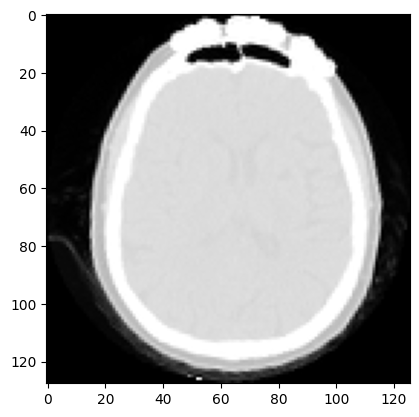

In [11]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")


In [12]:

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

ValueError: cannot reshape array of size 645120 into shape (4,10,128,128)

In [7]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
print(f"current batch_size:{batch_size}")

2023-12-21 08:07:41.752674: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2298478592 exceeds 10% of free system memory.
2023-12-21 08:07:43.503800: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2298478592 exceeds 10% of free system memory.


current batch_size:2


Visualize an augmented CT scan.

Since a CT scan has many slices, let's visualize a montage of the slices.

## Define a 3D convolutional neural network

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, regularizers

# Transfer learning from 3D-ResNet
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 64, 3))
base_model.trainable = False

# Building the model
model = models.Sequential()
model.add(layers.Resizing(128, 128, 64))  # Resizing if necessary
model.add(base_model)
model.add(layers.GlobalAveragePooling3D())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()


ValueError: `input_shape` must be a tuple of three integers.

## Train model

In [14]:
# Learning rate scheduler
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

# Compile model
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["accuracy", "AUC","Precision", "Recall"])

# Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=30, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[checkpoint_cb, early_stopping_cb],
    verbose=2)


Epoch 1/100
274/274 - 95s - loss: 0.7096 - accuracy: 0.4818 - auc: 0.4674 - precision: 0.4457 - recall: 0.3106 - val_loss: 0.7976 - val_accuracy: 0.5180 - val_auc: 0.4267 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 95s/epoch - 346ms/step
Epoch 2/100


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


274/274 - 86s - loss: 0.7034 - accuracy: 0.5073 - auc: 0.5034 - precision: 0.4864 - recall: 0.4053 - val_loss: 0.7016 - val_accuracy: 0.5252 - val_auc: 0.5247 - val_precision: 1.0000 - val_recall: 0.0149 - 86s/epoch - 315ms/step
Epoch 3/100
274/274 - 90s - loss: 0.7070 - accuracy: 0.4818 - auc: 0.4656 - precision: 0.4505 - recall: 0.3447 - val_loss: 0.6916 - val_accuracy: 0.5180 - val_auc: 0.5606 - val_precision: 0.5000 - val_recall: 0.0149 - 90s/epoch - 329ms/step
Epoch 4/100
274/274 - 95s - loss: 0.6991 - accuracy: 0.4964 - auc: 0.4885 - precision: 0.4717 - recall: 0.3788 - val_loss: 0.7142 - val_accuracy: 0.5108 - val_auc: 0.3122 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 95s/epoch - 345ms/step
Epoch 5/100
274/274 - 87s - loss: 0.7009 - accuracy: 0.4836 - auc: 0.4812 - precision: 0.4379 - recall: 0.2538 - val_loss: 0.8055 - val_accuracy: 0.5180 - val_auc: 0.4056 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 87s/epoch - 319ms/step
Epoch 6/100
274/274 - 88s - loss

KeyboardInterrupt: 

It is important to note that the number of samples is very small (only 200) and we don't
specify a random seed. As such, you can expect significant variance in the results. The full dataset
which consists of over 1000 CT scans can be found [here](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1). Using the full
dataset, an accuracy of 83% was achieved. A variability of 6-7% in the classification
performance is observed in both cases.

## Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.
Since the validation set is class-balanced, accuracy provides an unbiased representation
of the model's performance.

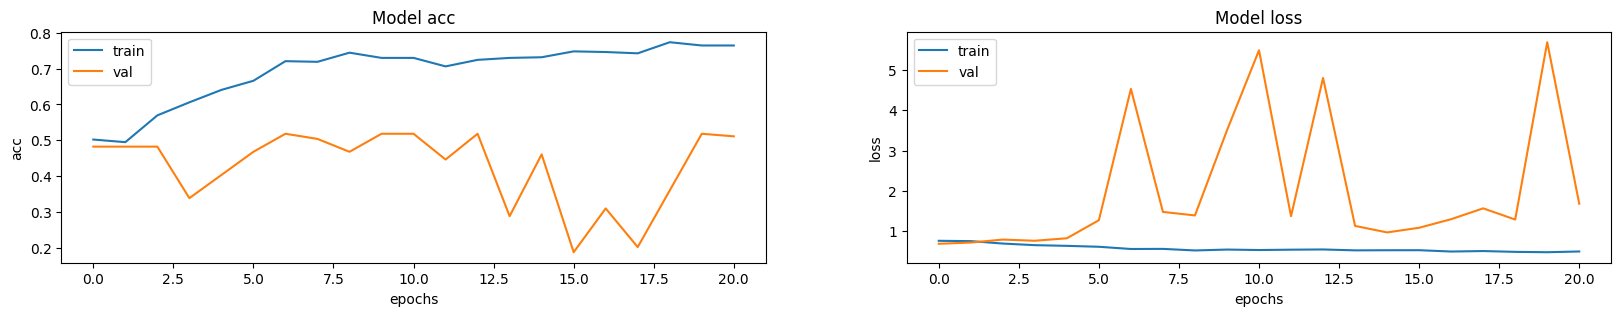

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Make predictions on a single CT scan

In [15]:

# Load best weights.
model.load_weights("best_model.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )
    print("And this is " + str(y_val[0]))


datagen = ImageDataGenerator()
generator = datagen.flow(x_val, batch_size=batch_size, shuffle=False)

y_pred = model.predict_generator(generator, steps=np.ceil(len(x_val) / batch_size))


y_pred_binary = (y_pred > 0.5).astype(int)


# метрики
accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


model.save("iz_3_buffed_image_save", save_format="tf")

plt.show()

1/1 [==============================] - 0s 170ms/step
This model is 53.25 percent confident that CT scan is normal
And this is 1
This model is 46.75 percent confident that CT scan is abnormal
And this is 1


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (139, 128, 128, 64) (64 channels).
  warnings.warn('NumpyArrayIterator is set to use the '
/tmp/ipykernel_1788/542923818.py:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(generator, steps=np.ceil(len(x_val) / batch_size))


Accuracy: 0.5179856115107914
Precision: 0.5
Recall: 0.014925373134328358
INFO:tensorflow:Assets written to: iz_3_buffed_image_save/assets


INFO:tensorflow:Assets written to: iz_3_buffed_image_save/assets
